<a href="https://colab.research.google.com/github/xunxunshi/stockIndicators/blob/main/Determining_Optimal_Stock_Indicator_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

--2021-04-16 15:51:43--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-04-16 15:51:44--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-04-16 15:51:44--  https://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.ne

In [3]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 5.5MB 4.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=4155a593c2093c35e7ad02375d2ad8952c239dfadc964311d5b4718762b1ad74
  Stored in directory: /tmp/pip-ephem-wheel-cache-durpjlcy/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
import talib as tb
import numpy as np

In [11]:
import datetime
from datetime import datetime,timedelta
today=datetime.date(datetime.now())+timedelta(days=1)
date_30_days_ago=today-timedelta(days=30)

In [6]:
import seaborn as sns
def returnHistory(stockName,inter,start,end,prepost='false'):
    stock_df= yf.Ticker(stockName).history(interval=inter,start=start,end=end,prepost=prepost)
    return stock_df


In [14]:

def quickSimulator(df,bankAccount,MoneyAllocatedToBuy,MoneyAllocatedToSell,RSI_buy,RSI_sell,stockName,conditionsNumToBuy):
    ifBuy=False
    ifSell=False 
    ifBuyingCondition=False
    numOfBuyingSatisified=0 
    numberOfStocks=0  
    currentPosition='Hold'
    mostRecentSellDate=None
    mostRecentBuyDate=None
    
    ifRSI=False
    ifBBandsBuy=False
    ifHammer=False
    ifEMA20Indicator =False 
    ifEMA9Indicator=False
    ifVWAPIndicator=False  
    startOfBuyCounter=0
    df_return=[]
    df_return.append(stockName)
    df_return.append(bankAccount)
    df_return.append(MoneyAllocatedToBuy)
    df_return.append(MoneyAllocatedToSell) 
    NumberOfBuys=0
    NumberOfSells=0
    for index,row in df.iterrows():
        
        if(currentPosition=='Hold'):
            ## BUY CONDITIONS ( SEVERAL / START LOOKING FOR PATTERN )
            if(not (ifEMA20Indicator or ifEMA9Indicator or ifVWAPIndicator)):
                if(row['Close']<row['20EMA']):
                    ifEMA20Indicator=True
                if(row['Close']<row['9EMA']):
                    ifEMA9Indicator=True
                if(row['Close']<row['VWAP']):
                    ifVWAPIndicator=True 
                if(ifEMA20Indicator or ifEMA9Indicator or ifVWAPIndicator):
                    numOfBuyingSatisified=numOfBuyingSatisified+1 
            if(ifBBandsBuy==False ):
                if((row['differnceBetweenLower']<0) & (row['% volume']>1)):
                    numOfBuyingSatisified=numOfBuyingSatisified+1  
                    ifBBandsBuy=True  
            if(ifRSI==False ):     
                if((row['RSI']<RSI_buy)& (row['% volume']>1)):
                    numOfBuyingSatisified=numOfBuyingSatisified+1  
                    ifRSI=True  
            if(ifHammer==False ):    
                if((row['Hammer']==100)& (row['% volume']>1)):
                    numOfBuyingSatisified=numOfBuyingSatisified+1  
                    ifHammer=True 
            ## IF PATTERN IS SATISIFIED OR THE WE DID THIS 6 TIMES AND DID NOT FIND A PATTERN 
            if(startOfBuyCounter is not None):
                if((numOfBuyingSatisified>=conditionsNumToBuy) or (startOfBuyCounter>6)):
                    ## buy  
                    
                    startOfBuyCounter=0 
                    ifEMA20Indicator=False
                    ifEMA9Indicator=False
                    ifVWAPIndicator=False
                    ifBBandsBuy=False
                    ifRSI=False
                    ifHammer=False 
                    if(numOfBuyingSatisified>=conditionsNumToBuy):
                        currentPosition='Buy'                   
                        ifSell=False 
                        if (mostRecentBuyDate is None):
                            ifBuy=True
                            numOfBuyingSatisified=0
                        else:
                            if((divmod(index-mostRecentBuyDate,60)[0].seconds/60)>10):
                                ifBuy=True
                                numOfBuyingSatisified=0 
                    numOfBuyingSatisified=0 
                    
            if(currentPosition!='Buy'): ## buying conditions not satisifeid 
                if(mostRecentBuyDate is not None):
                    condition_one=(((divmod(index-mostRecentBuyDate,60)[0].seconds/60)>10)& (ifEMA20Indicator==True )&(row['Close']>row['20EMA']))
                    condition_two=(((divmod(index-mostRecentBuyDate,60)[0].seconds/60)>10)& (ifEMA9Indicator==True)&(row['Close']>row['9EMA']))
                    condition_three=(((divmod(index-mostRecentBuyDate,60)[0].seconds/60)>10)& (ifVWAPIndicator==True)&(row['Close']>row['VWAP']))
                    condition_four=(row['RSI']>RSI_sell)
                    condition_five=(row['Shooting Star']==-100 and row['% volume'])
                    condition_six=(row['differnceBetweenUpper']<1)

                    ##if(condition_one or condition_two or condition_three or condition_four or condition_five or condition_six ) :
                   
                    if((condition_four and condition_five) or( condition_four and condition_six) ) :
                        ifBuy=False
                        ifSell=True 
                        currentPosition='Sell'
                    else:
                        ifBuy=False
                        ifSell=False
                        currentPosition='Hold'
                else:
                    ifBuy=False
                    ifSell=False
                    currentPosition='Hold'
        elif(currentPosition=='Buy'):
            ## if row['RSI']<30 it stays at current state 
                condition_four=(row['RSI']>RSI_sell)
                condition_five=(row['Shooting Star']==-100 and row['% volume'])
                condition_six=(row['differnceBetweenUpper']<1)

                if((condition_four and condition_five) or( condition_four and condition_six) ) :
                    ifBuy=False
                    ifSell=True 
                    currentPosition='Sell' 
                else:  
                    currentPosition='Hold'
                    
                    
                   
        else:## currentPosition='Sell'
            if(not (ifEMA20Indicator or ifEMA9Indicator or ifVWAPIndicator)):
                if(row['Close']<row['20EMA']):
                    ifEMA20Indicator=True
                if(row['Close']<row['9EMA']):
                    ifEMA9Indicator=True
                if(row['Close']<row['VWAP']):
                    ifVWAPIndicator=True 
                if(ifEMA20Indicator or ifEMA9Indicator or ifVWAPIndicator):
                    numOfBuyingSatisified=numOfBuyingSatisified+1  
            if(ifBBandsBuy==False ):
                if((row['differnceBetweenLower']<0) & (row['% volume']>1)):
                    numOfBuyingSatisified=numOfBuyingSatisified+1  
                    ifBBandsBuy=True 
            if(ifRSI==False ):     
                if((row['RSI']<RSI_buy)& (row['% volume']>1)):
                    numOfBuyingSatisified=numOfBuyingSatisified+1  
                    ifRSI=True 
            if(ifHammer==False ):     
                if((row['Hammer']==100)& (row['% volume']>1)):
                    numOfBuyingSatisified=numOfBuyingSatisified+1  
                    ifHammer=True
            ## IF PATTERN IS SATISIFIED OR THE WE DID THIS 6 TIMES AND DID NOT FIND A PATTERN 
            if(startOfBuyCounter is not None):
                if((numOfBuyingSatisified>=conditionsNumToBuy) or (startOfBuyCounter>6)):
                    ## buy 
                    startOfBuyCounter=0 
                    ifEMA20Indicator=False
                    ifEMA9Indicator=False
                    ifVWAPIndicator=False
                    ifBBandsBuy=False
                    ifRSI=False
                    ifHammer=False
                    if(numOfBuyingSatisified>=conditionsNumToBuy):
                        currentPosition='Buy'
                        ifSell=False
                        if (mostRecentBuyDate is None):
                            numOfBuyingSatisified=0
                            ifBuy=True
                        else:
                            if((divmod(index-mostRecentBuyDate,60)[0].seconds/60)>10):
                                numOfBuyingSatisified=0
                                ifBuy=True 
                numOfBuyingSatisified=0 
               
            if(currentPosition!='Buy'): 
                ## Sell or Hold conditions
                if(mostRecentBuyDate is not None):
                    condition_one=(((divmod(index-mostRecentBuyDate,60)[0].seconds/60)>10)& (ifEMA20Indicator==True )&(row['Close']>row['20EMA']))
                    condition_two=(((divmod(index-mostRecentBuyDate,60)[0].seconds/60)>10)& (ifEMA9Indicator==True)&(row['Close']>row['9EMA']))
                    condition_three=(((divmod(index-mostRecentBuyDate,60)[0].seconds/60)>10)& (ifVWAPIndicator==True)&(row['Close']>row['VWAP']))
                    condition_four=(row['RSI']>RSI_sell)
                    condition_five=(row['Shooting Star']==-100 and row['% volume'])
                    condition_six=(row['differnceBetweenUpper']<1)

                    ##if(condition_one or condition_two or condition_three or condition_four or condition_five or condition_six ) :
                    if( (condition_four and condition_five) or( condition_four and condition_six)) :
                        print('ifsell in Sell')
                        currentPosition='Hold'
                        if(mostRecentSellDate is None): 
                            ifSell=True
                        else:
                            if((divmod(index-mostRecentBuyDate,60)[0].seconds/60)>10):
                                ifSell=True
                else:
                     currentPosition='Hold'
        if(numOfBuyingSatisified>0):
            if(numOfBuyingSatisified==1):
                startOfBuyCounter=1
            else:
                startOfBuyCounter=startOfBuyCounter+1
        else:
            startOfBuyCounter=0
        if((ifBuy==False)&(ifSell==False)):
            networth=bankAccount+numberOfStocks*row['Close']
        
        if(ifBuy==True):
            #print('bank account at '+str(bankAccount))
            numberOfStocksToBuy=round(MoneyAllocatedToBuy/row['Close'])
            if((bankAccount-numberOfStocksToBuy*row['Close'])>0):

                bankAccount=bankAccount-numberOfStocksToBuy*row['Close']
                numberOfStocks=numberOfStocks+numberOfStocksToBuy
                print(index)
                print(' we are buying'+ str(numberOfStocksToBuy)+'stocks at a price of '+str(row['Close'])+'at a RSI of '+str(row['RSI']))
                print('bank account updated to be '+str(bankAccount))
                mostRecentBuyDate=index
                networth=bankAccount+numberOfStocks*row['Close']
                NumberOfBuys+=1

            else:
                networth=bankAccount+numberOfStocks*row['Close'] 
                print(index)
                print('we wanted to buy at '+str(numberOfStocksToBuy)+'stocks at a price of '+str(row['Close'])+'at a RSI of '+str(row['RSI']))
                print('we ran out of money !')
            ifBuy=False
        if(ifSell==True):
            ifEMA20Indicator=False 
            ifEMA9Indicator=False 
            ifVWAPIndicator=False 
            numberOfStocksToSell=round(MoneyAllocatedToBuy/row['Close'])
            if(numberOfStocks>numberOfStocksToSell):
                bankAccount=bankAccount+numberOfStocksToSell*row['Close']
                numberOfStocks=numberOfStocks-numberOfStocksToSell
                networth=bankAccount+numberOfStocks*row['Close'] 
                print(index)
                print(' we are selling '+ str(numberOfStocksToBuy)+'stocks at a price of '+str(row['Close'])+'at a RSI of '+str(row['RSI']))
                print('bank account updated to be '+str(bankAccount))
                mostRecentSellDate=index
                NumberOfSells+=1

            else:
                networth=bankAccount+numberOfStocks*row['Close'] 
                print(index)
                print('we wanted to sell at '+str(numberOfStocksToSell)+'stocks at a price of '+str(row['Close'])+'at a RSI of '+str(row['RSI']))
                print('we ran out of stocks !')
            ifSell=False
    df_return.append(NumberOfBuys)
    df_return.append(NumberOfSells)
    df_return.append(bankAccount)
    df_return.append(numberOfStocks)
    df_return.append(df['Close'].iloc[-1])
    df_return.append(RSI_buy)
    df_return.append(RSI_sell)
    df_return.append(conditionsNumToBuy)
    df_return.append(networth)
    return (df_return)

In [16]:
stock_daily=returnHistory('DIS','1d','2019-01-01',today)
stock_5min=returnHistory('DIS','5m',date_30_days_ago,today)
stock_5min['VWAP']=stock_5min.groupby(stock_5min.index.date).apply(lambda x: ((x['High']+x['Low']+x['Close'])/3*x['Volume']).cumsum()/x['Volume'].cumsum()).reset_index()[0].values

daily_average_volume=stock_5min.groupby(stock_5min.index.time).apply(lambda x: ( (x['Volume'].cumsum() / pd.Series(np.arange(1, len(x['Volume'])+1), x['Volume'].index)))).to_frame().reset_index().rename(columns={'index':'Datetime',0:'volume'})
stock_5min['daily volume at this time']=daily_average_volume['volume'].values
stock_5min['% volume']=stock_5min['Volume']/stock_5min['daily volume at this time']


stock_5min['RSI']=tb.RSI(stock_5min['Close'],timeperiod=14)
## criteria for RSI <10 
bband=tb.BBANDS(stock_5min['Close'],timeperiod=14)

stock_5min['differnceBetweenUpper']=stock_5min['Close']-bband[0]## has to be positive 
stock_5min['differnceBetweenLower']=stock_5min['Close']-bband[2]## has to be negative 

## should you calculate the EMA by using grouped data for thhe time? 
stock_5min['9EMA']=tb.EMA(stock_5min['Close'],timeperiod=9)
stock_5min['20EMA']=tb.EMA(stock_5min['Close'],timeperiod=20)

stock_5min['Hammer']=tb.CDLHAMMER(stock_5min['Open'], stock_5min['High'], stock_5min['Low'], stock_5min['Close'])
## critria for hammer ==100
stock_5min['Shooting Star']=tb.CDLSHOOTINGSTAR(stock_5min['Open'], stock_5min['High'], stock_5min['Low'], stock_5min['Close'])
## criteria for shooting star ==-100 
l=quickSimulator(stock_5min,10000,2000,2000,30,70,'DIS',3)

2021-03-19 09:30:00-04:00
 we are buying10stocks at a price of 190.64999389648438at a RSI of 25.98141950207679
bank account updated to be 8093.500061035156
2021-03-19 15:05:00-04:00
we wanted to sell at 10stocks at a price of 193.11000061035156at a RSI of 73.27609393982925
we ran out of stocks !
ifsell in Sell
2021-03-19 15:10:00-04:00
we wanted to sell at 10stocks at a price of 193.27999877929688at a RSI of 75.23311538444383
we ran out of stocks !
2021-03-19 15:30:00-04:00
we wanted to sell at 10stocks at a price of 193.61000061035156at a RSI of 71.91063369036075
we ran out of stocks !
ifsell in Sell
2021-03-19 15:45:00-04:00
we wanted to sell at 10stocks at a price of 193.75999450683594at a RSI of 70.69952966970978
we ran out of stocks !
2021-03-22 09:55:00-04:00
 we are buying10stocks at a price of 194.9600067138672at a RSI of 65.24556913807558
bank account updated to be 6143.899993896484
2021-03-22 10:15:00-04:00
 we are selling 10stocks at a price of 196.22650146484375at a RSI of 

In [52]:
stock_daily=returnHistory('DIS','1d','2017-01-01',today)

In [133]:
def plotIndicatorBuySell(stock_daily,stockName):

  fig, axs = plt.subplots(2, 2,figsize=(30,15))
  axs[0,1].plot(stock_daily['Close'])

  axs[0,1].scatter(stock_daily[stock_daily['MFI']>80].index,stock_daily[stock_daily['MFI']>80]['Close'],label='sell #:'+str(len(stock_daily[stock_daily['MFI']>80].index)),color='black')
  axs[0,1].scatter(stock_daily[stock_daily['MFI']<20].index,stock_daily[stock_daily['MFI']<20]['Close'],label='buy #:'+str(len(stock_daily[stock_daily['MFI']<20].index)),color='red')
  axs[0,1].set_title(stockName+':MFI')
  

  axs[0,0].plot(stock_daily['Close'])
  axs[0,0].scatter(stock_daily[stock_daily['RSI']>70].index,stock_daily[stock_daily['RSI']>70]['Close'],label='sell #:'+str(len(stock_daily[stock_daily['RSI']>70].index)),color='black')
  axs[0,0].scatter(stock_daily[stock_daily['RSI']<30].index,stock_daily[stock_daily['RSI']<30]['Close'],label='buy #:'+str(len(stock_daily[stock_daily['RSI']<30].index)),color='red') 
  axs[0,0].set_title(stockName+':RSI')

  
  axs[1,0].plot(stock_daily['Close'])
  axs[1,0].scatter(stock_daily[stock_daily['differnceBetweenUpper']>0].index,stock_daily[stock_daily['differnceBetweenUpper']>0]['Close'],label='sell #:'+str(len(stock_daily[stock_daily['differnceBetweenUpper']>0].index)),color='black')
  axs[1,0].scatter(stock_daily[stock_daily['differnceBetweenLower']<0].index, stock_daily[stock_daily['differnceBetweenLower']<0]['Close'],label='buy #:'+str(len(stock_daily[stock_daily['differnceBetweenLower']<0].index)),color='red')
  axs[1,0].set_title(stockName+':BBands')


  axs[1,1].plot(stock_daily['Close'])
  axs[1,1].scatter(stock_daily[(stock_daily['differnceBetweenUpper']>0)&(stock_daily['RSI']>70) &(stock_daily['MFI']>70)].index,stock_daily[(stock_daily['differnceBetweenUpper']>0)&(stock_daily['RSI']>70) &(stock_daily['MFI']>70)]['Close'],label='sell #:'+str(len(stock_daily[(stock_daily['differnceBetweenUpper']>0)&(stock_daily['RSI']>70) &(stock_daily['MFI']>70)].index)),color='black')
  axs[1,1].scatter(stock_daily[(stock_daily['differnceBetweenLower']<0)&(stock_daily['RSI']>30) &(stock_daily['MFI']<30)].index,stock_daily[(stock_daily['differnceBetweenLower']<0)&(stock_daily['RSI']>30) &(stock_daily['MFI']<30)]['Close'],label='buy #:'+str(len(stock_daily[(stock_daily['differnceBetweenLower']<0)&(stock_daily['RSI']>30) &(stock_daily['MFI']<30)].index)),color='red')
  axs[1,1].set_title(stockName+':BBands+MFI+RIS')

  axs[0,0].legend()
  axs[0,1].legend()
  axs[1,0].legend()
  axs[1,1].legend()

## Trading Visualization Based on Indicators

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

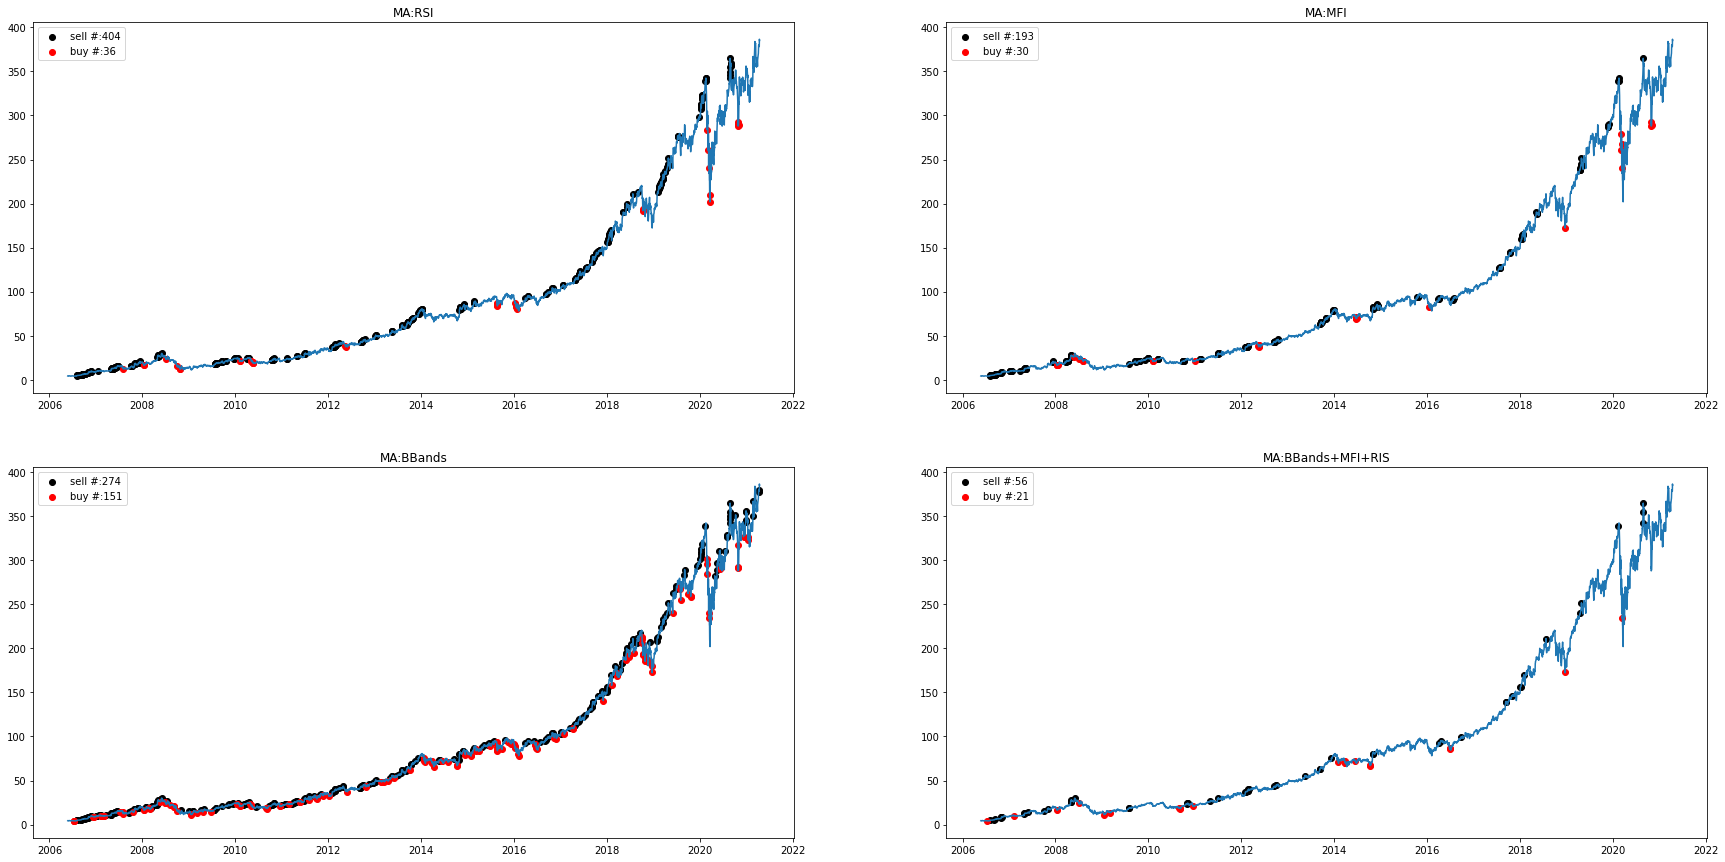

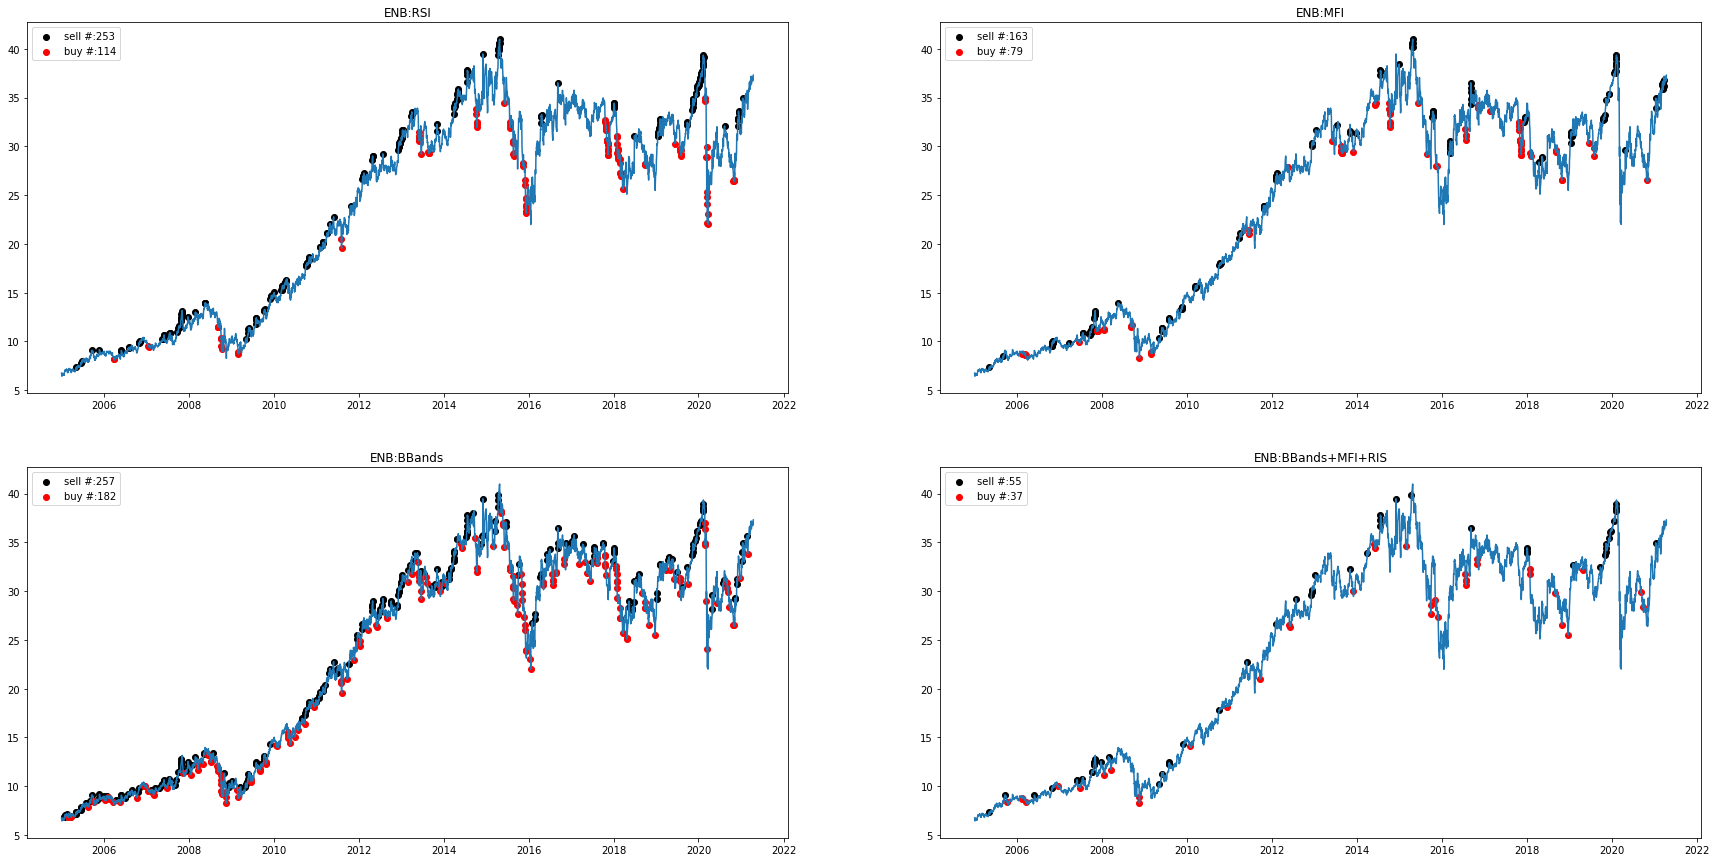

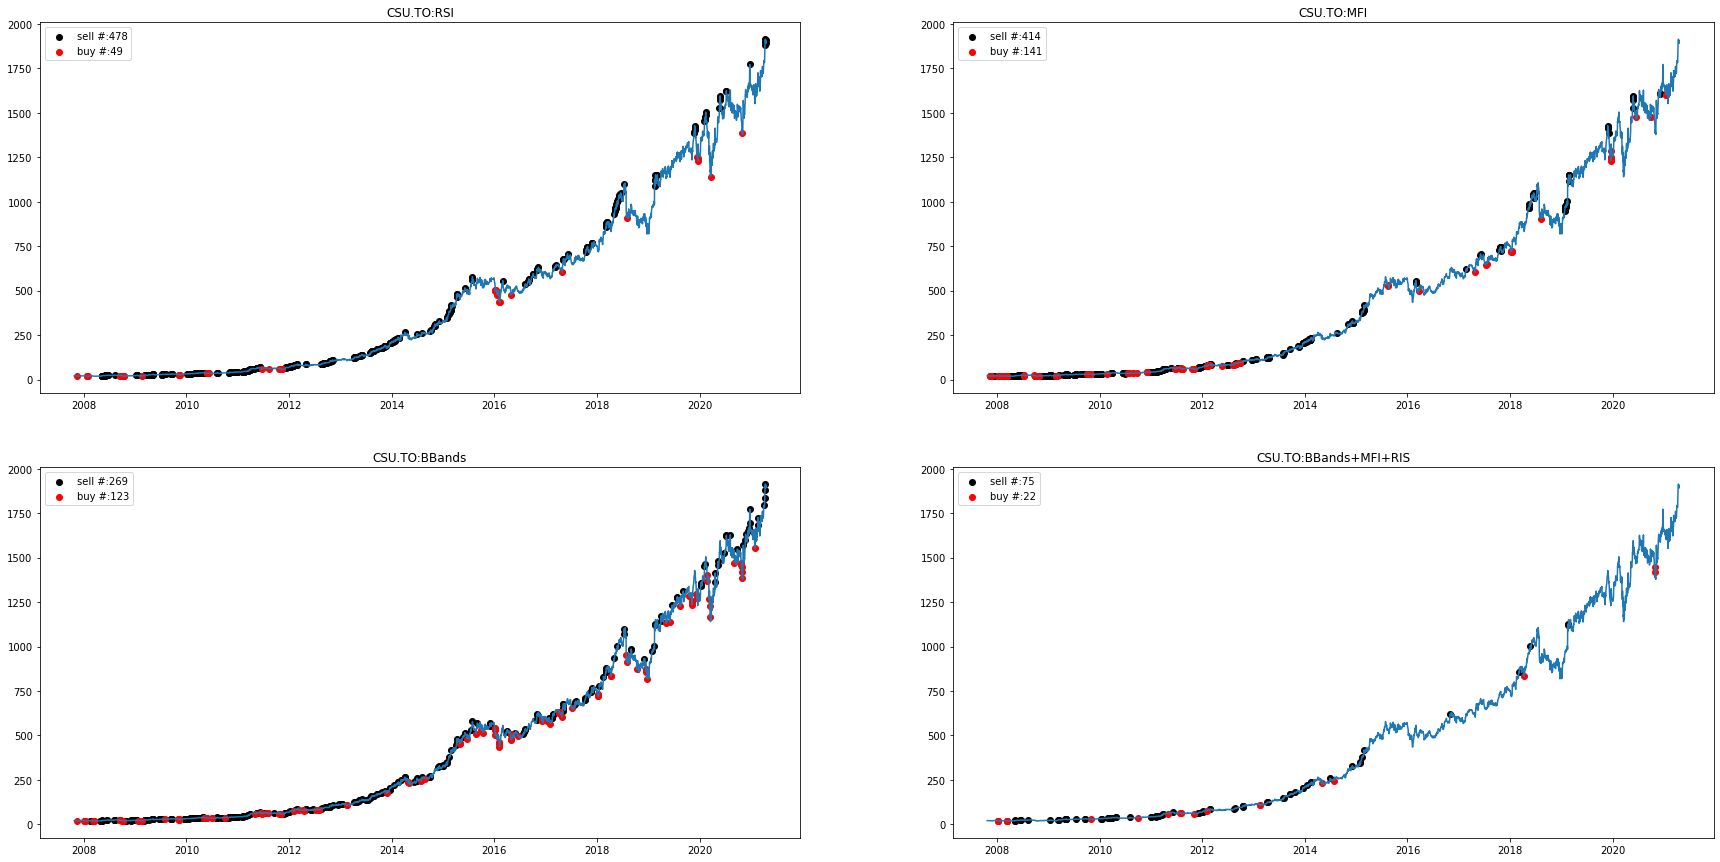

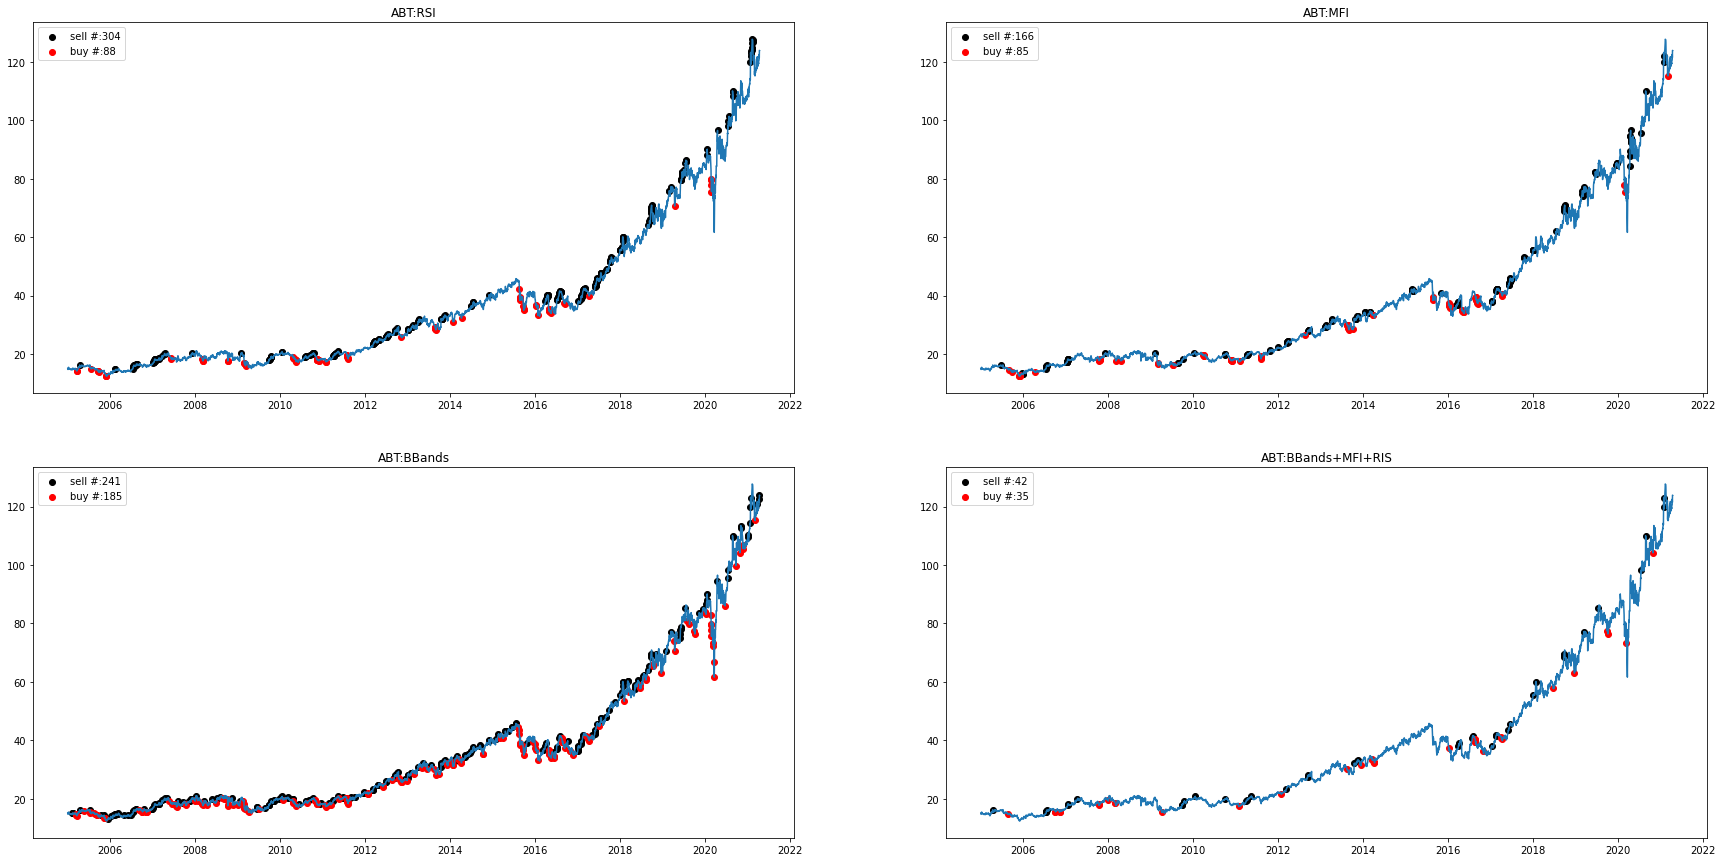

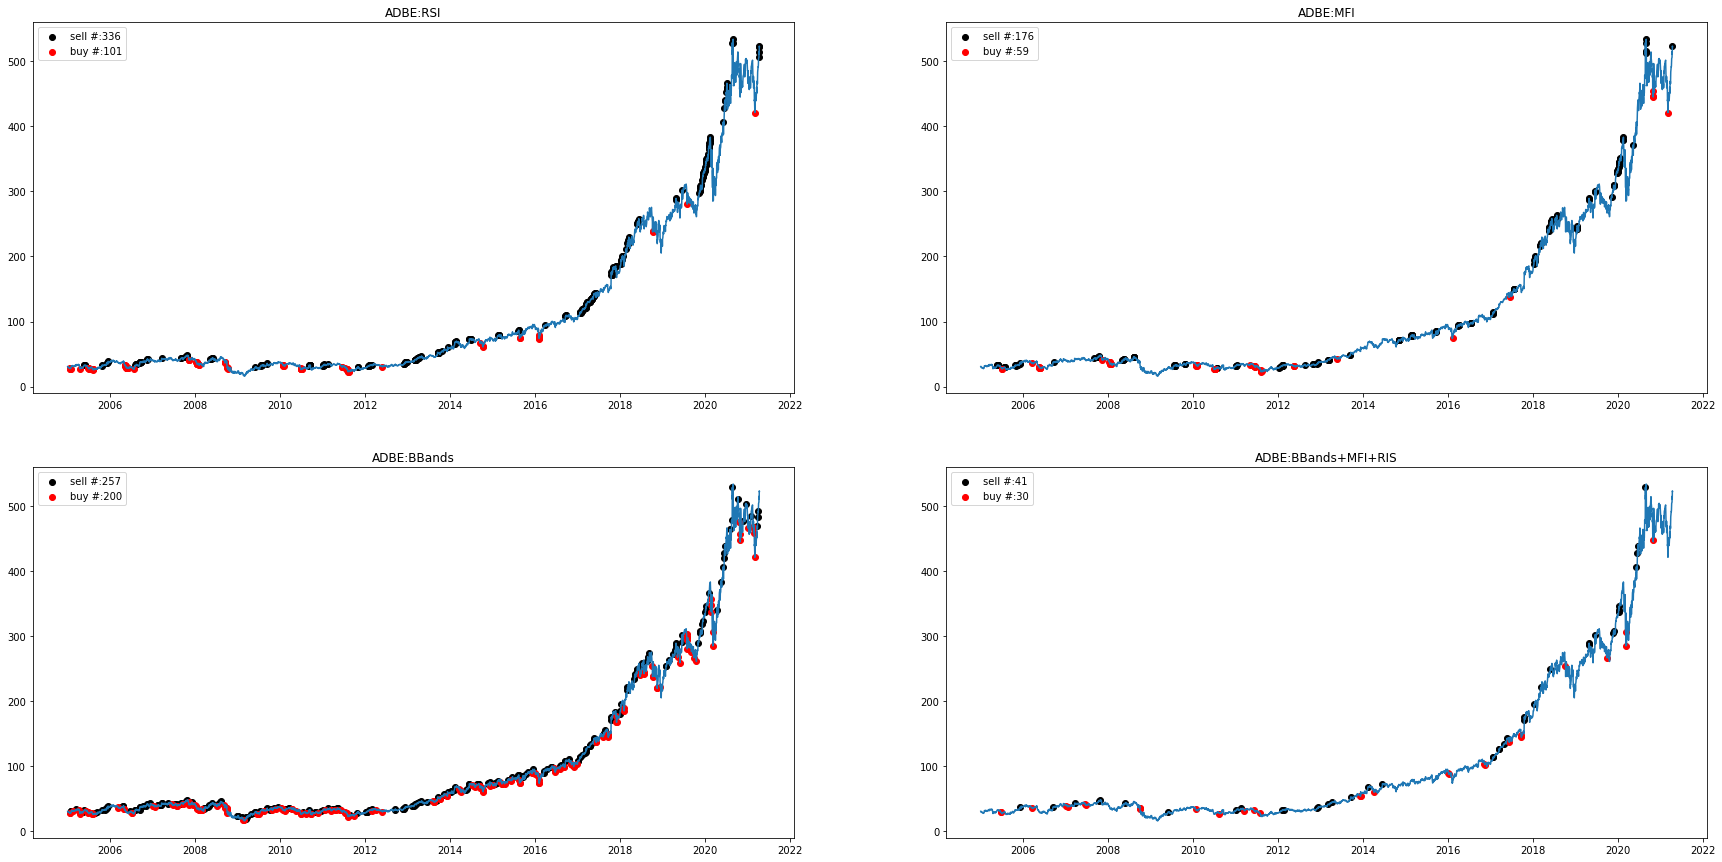

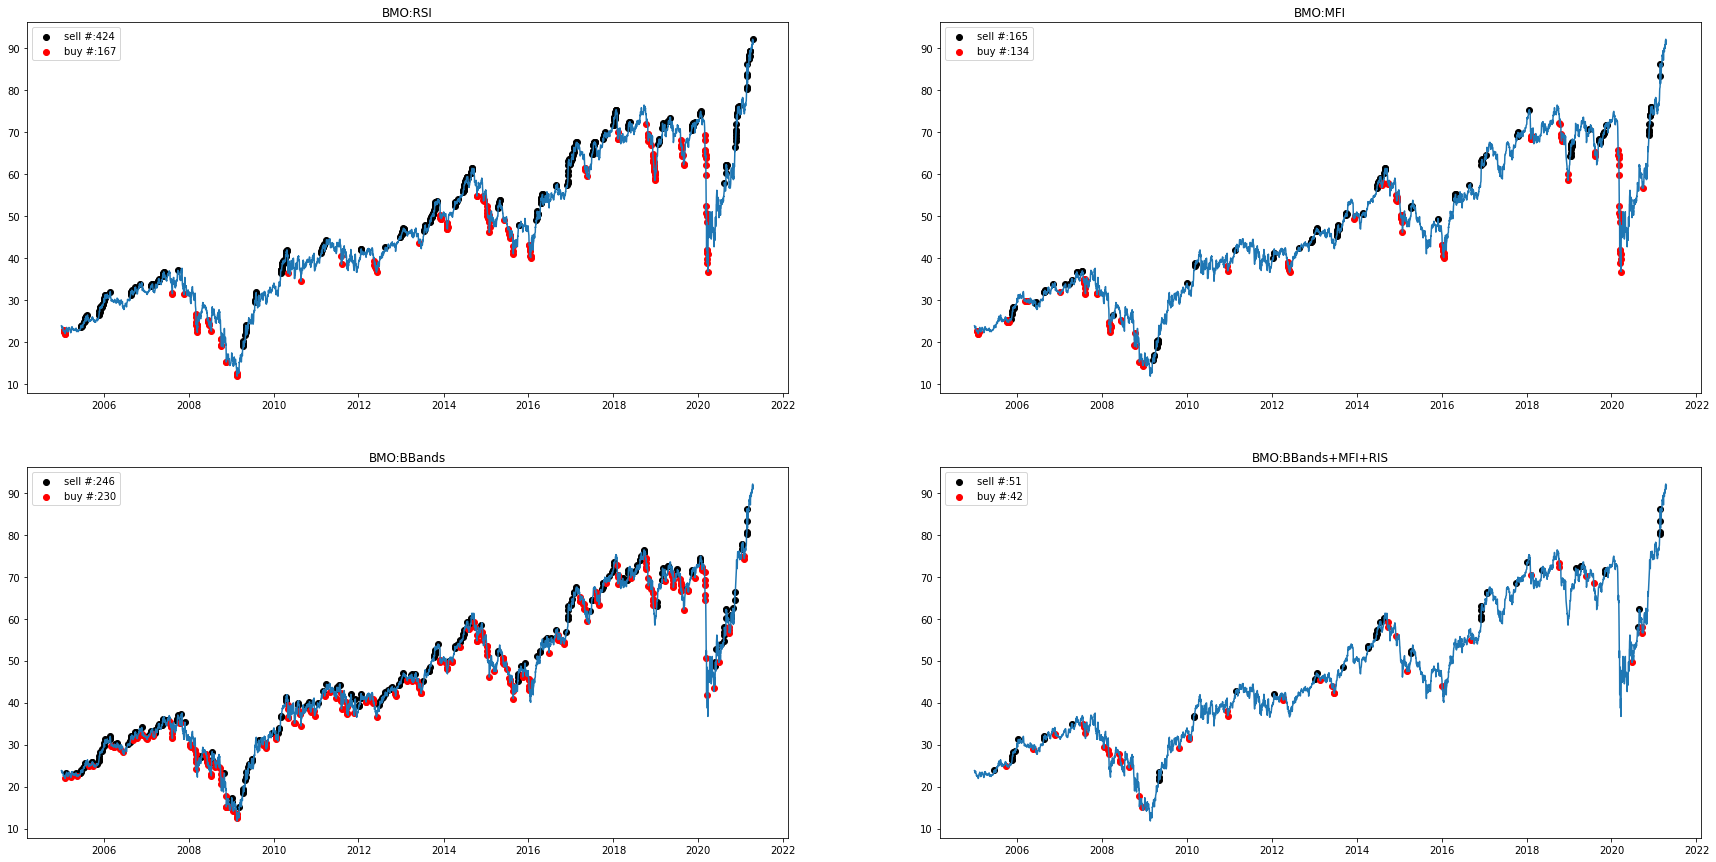

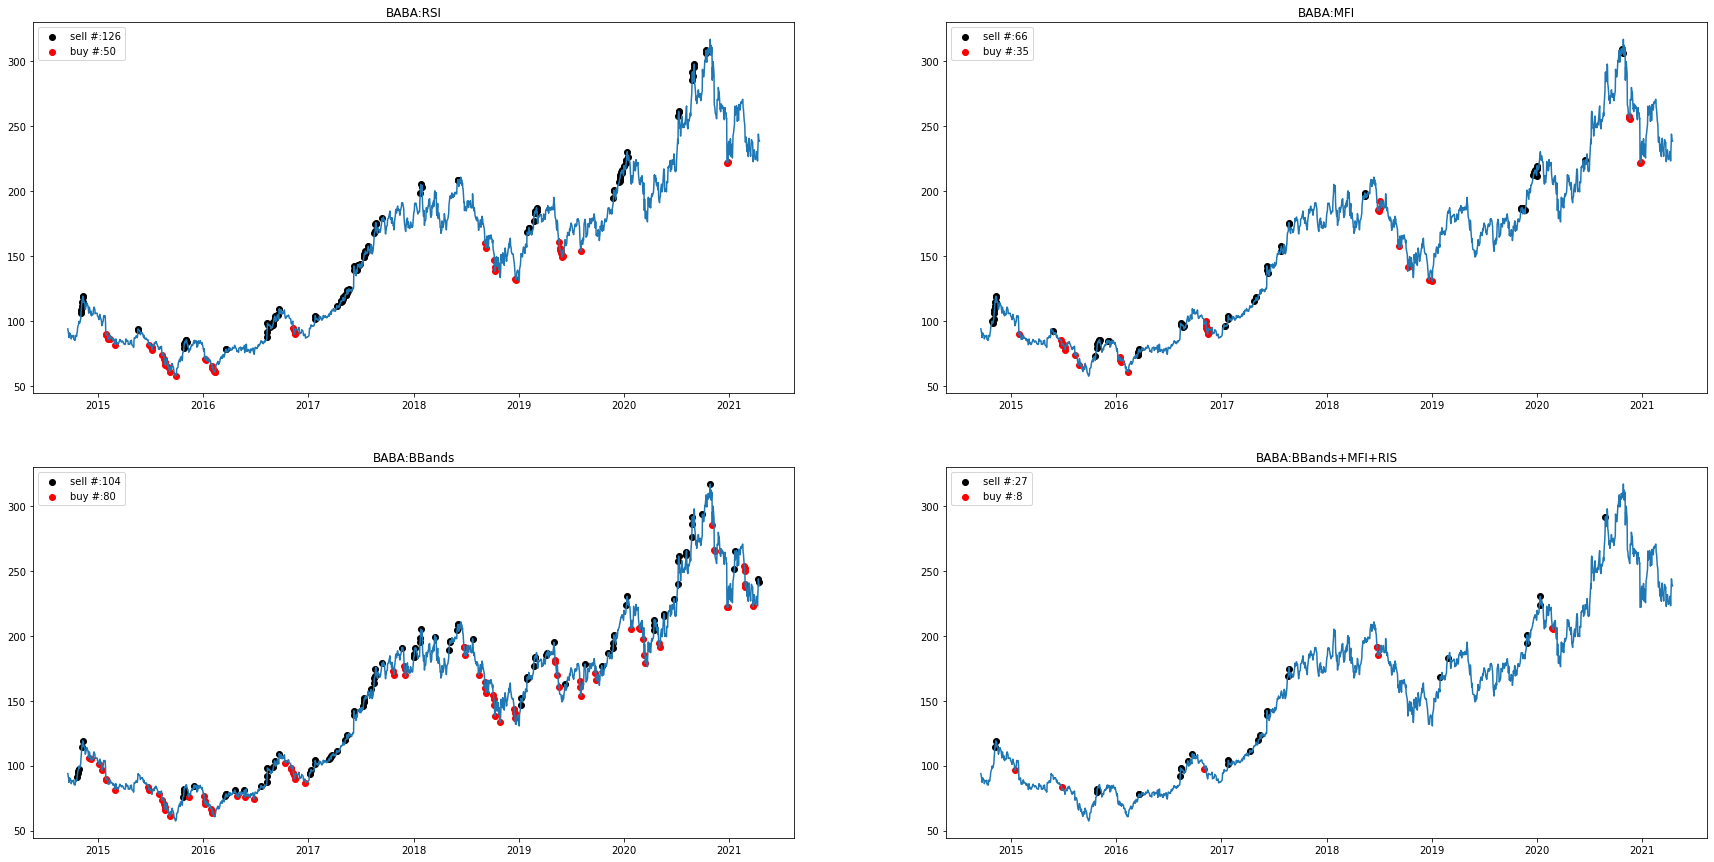

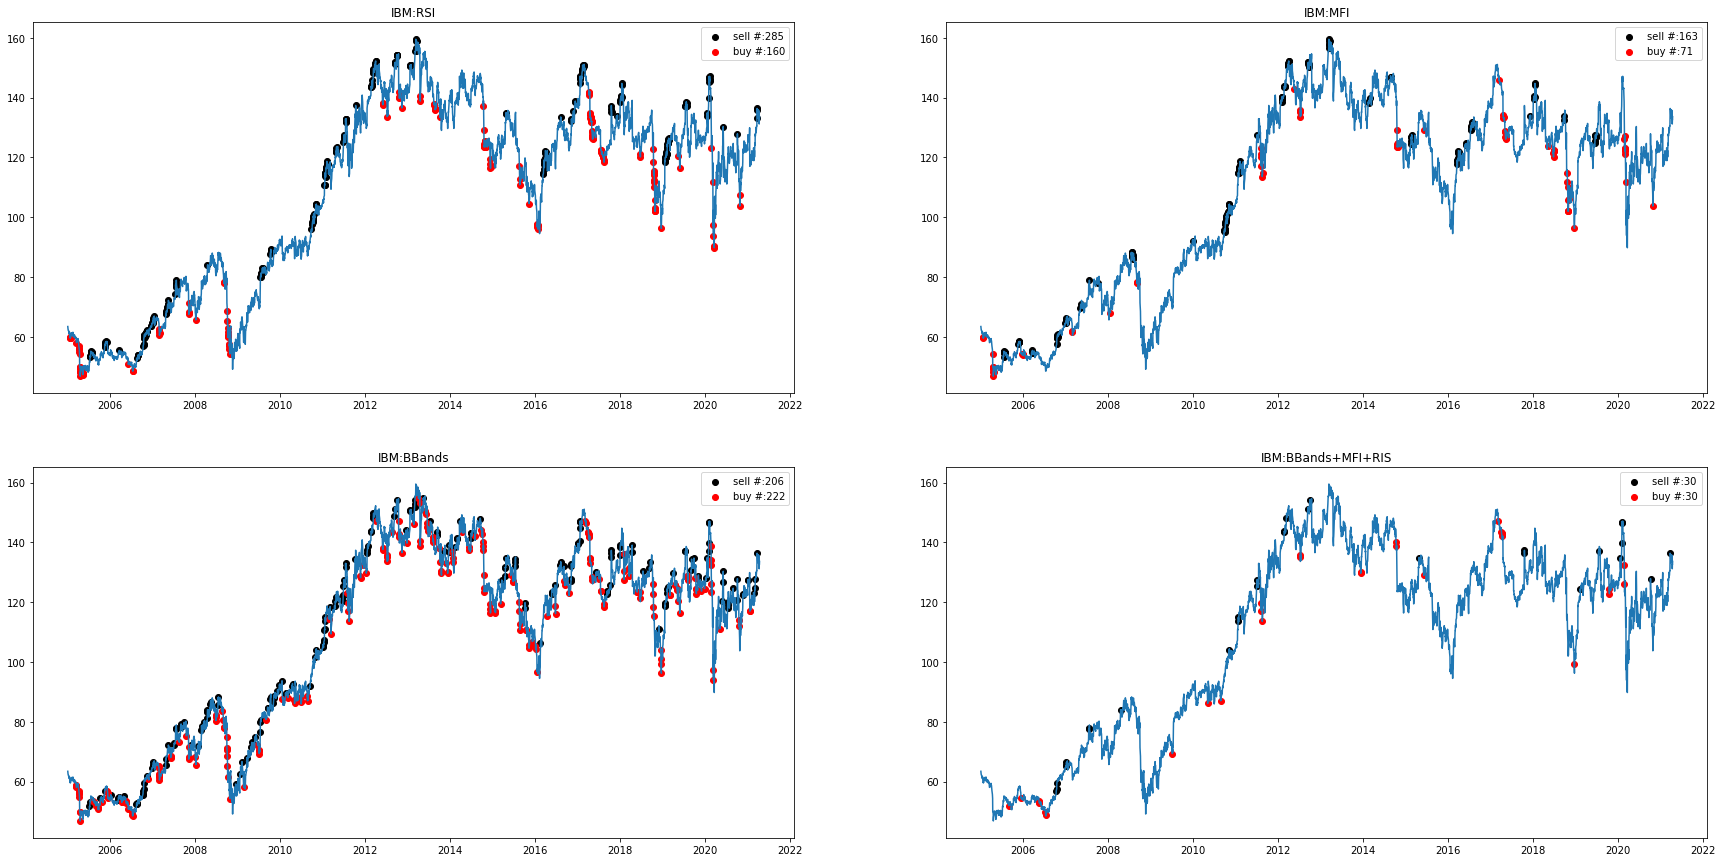

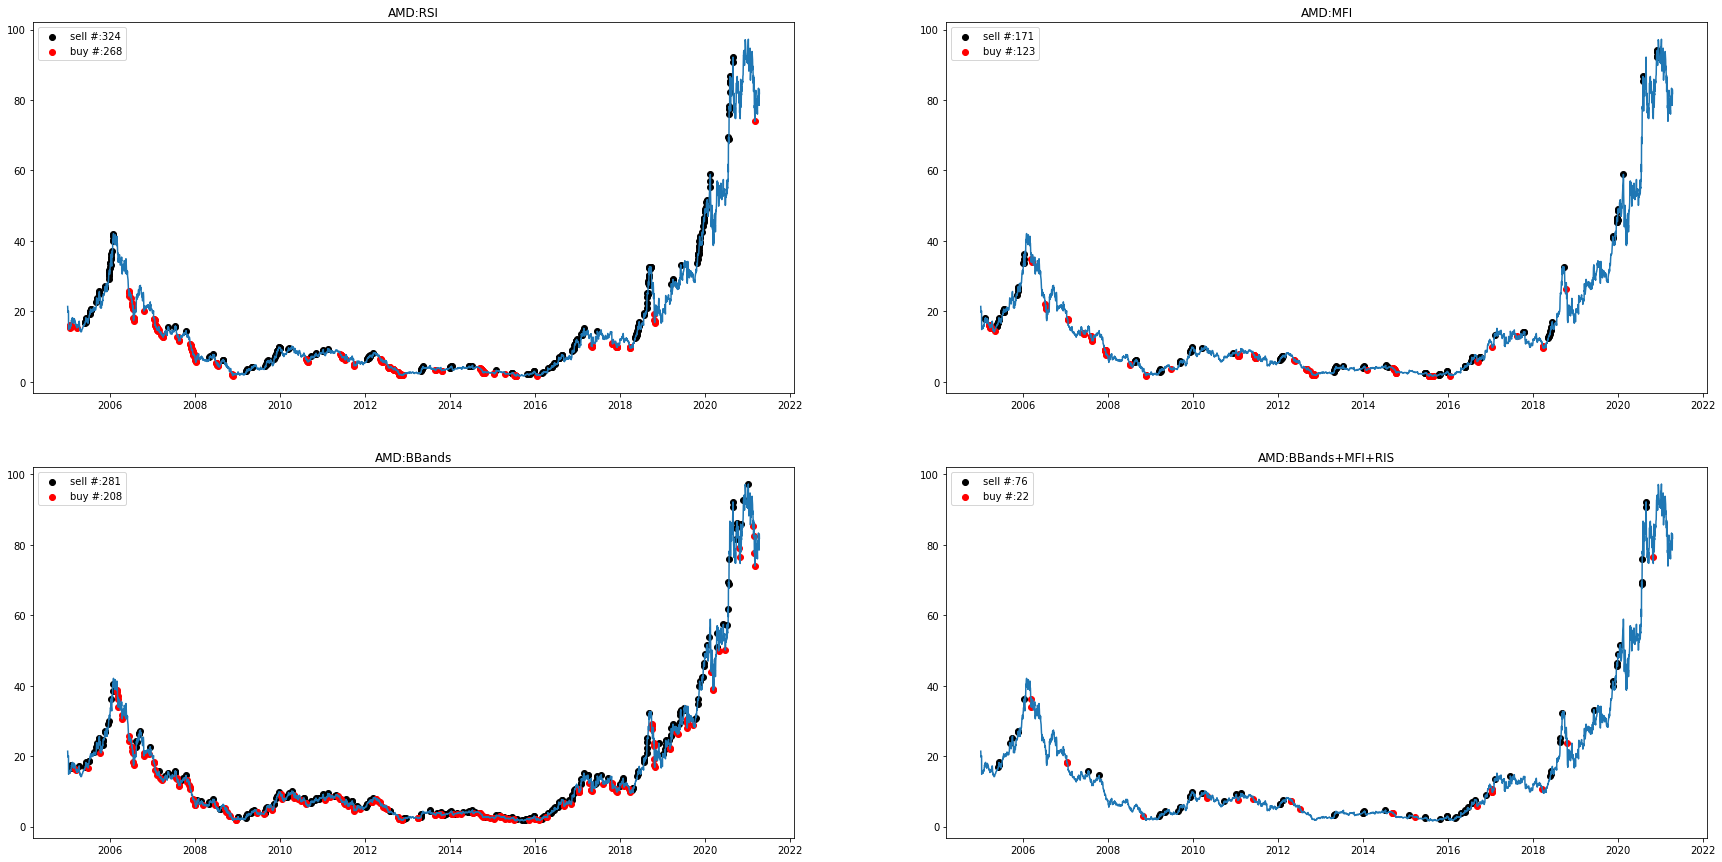

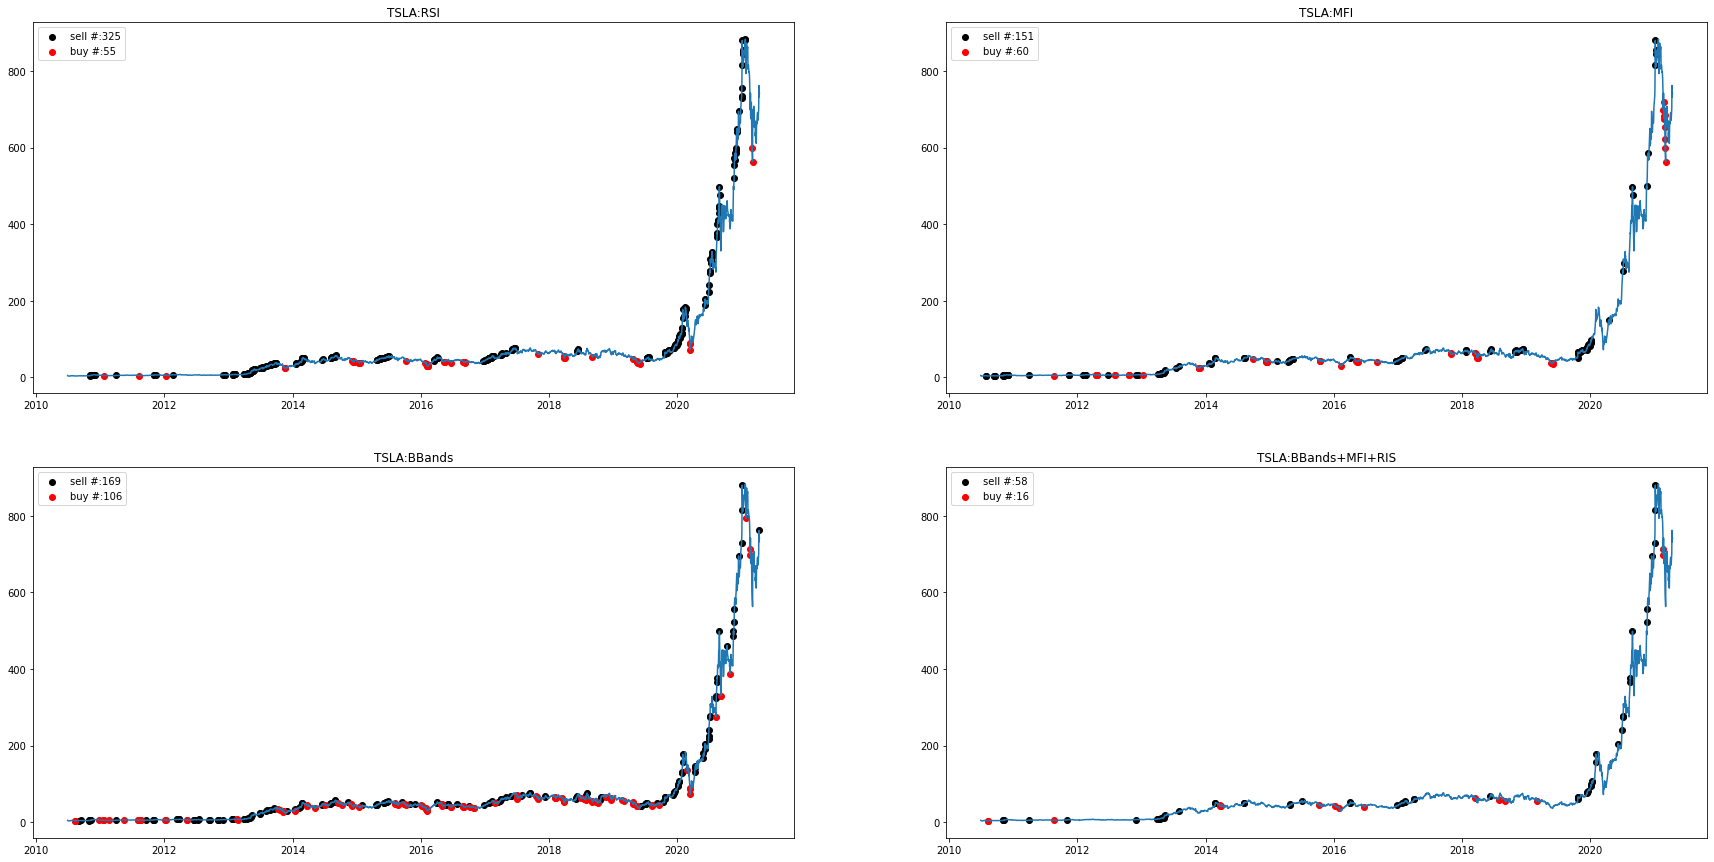

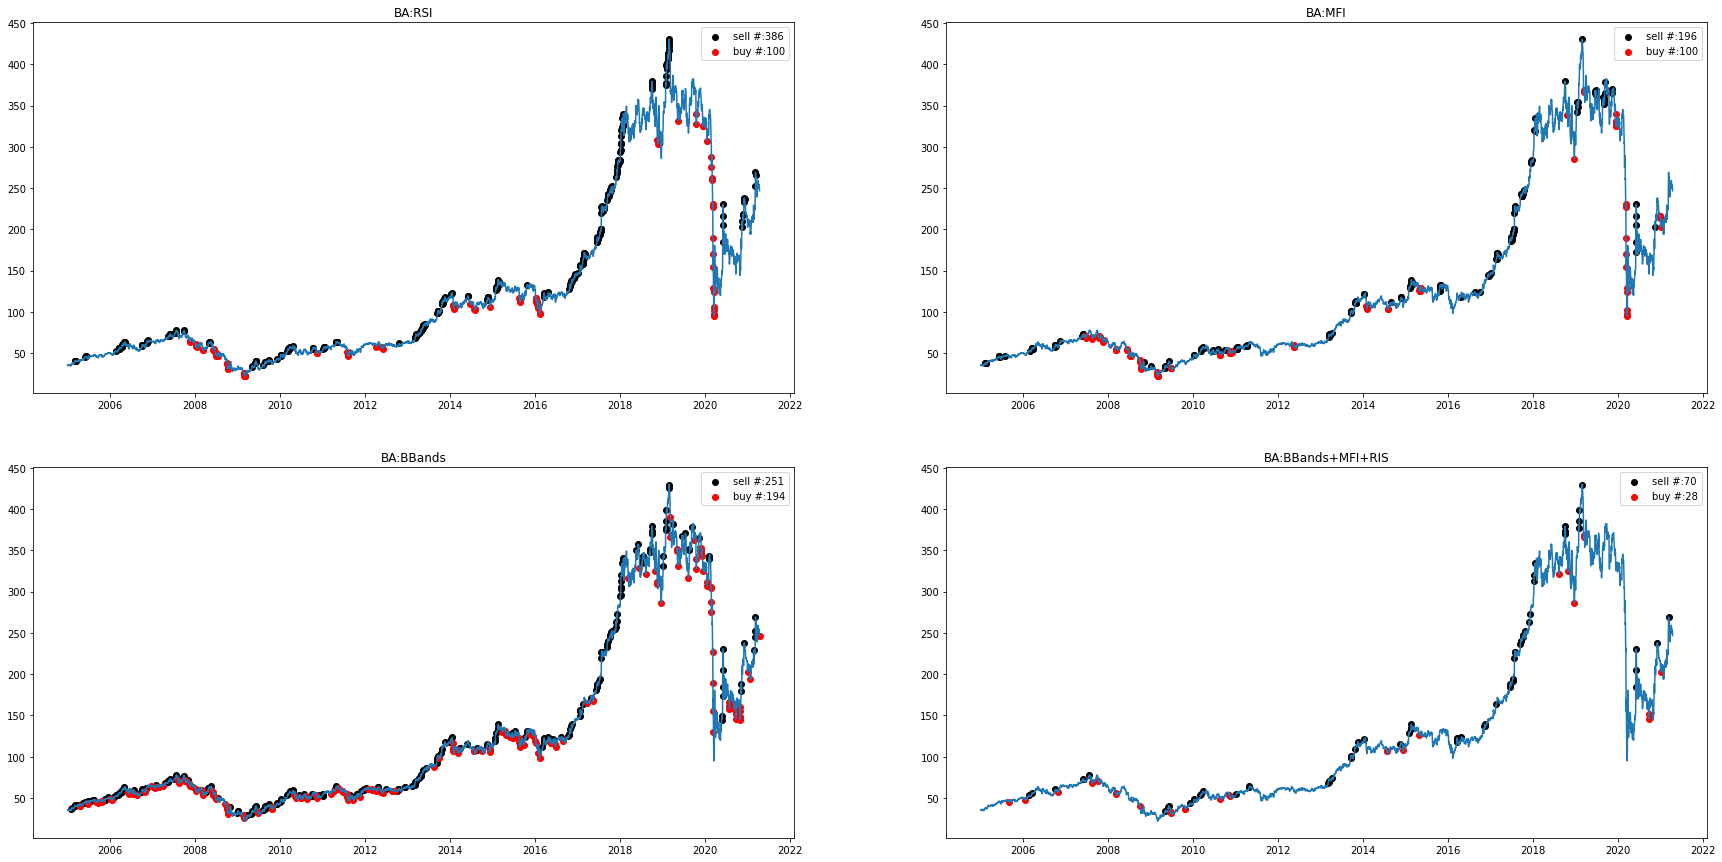

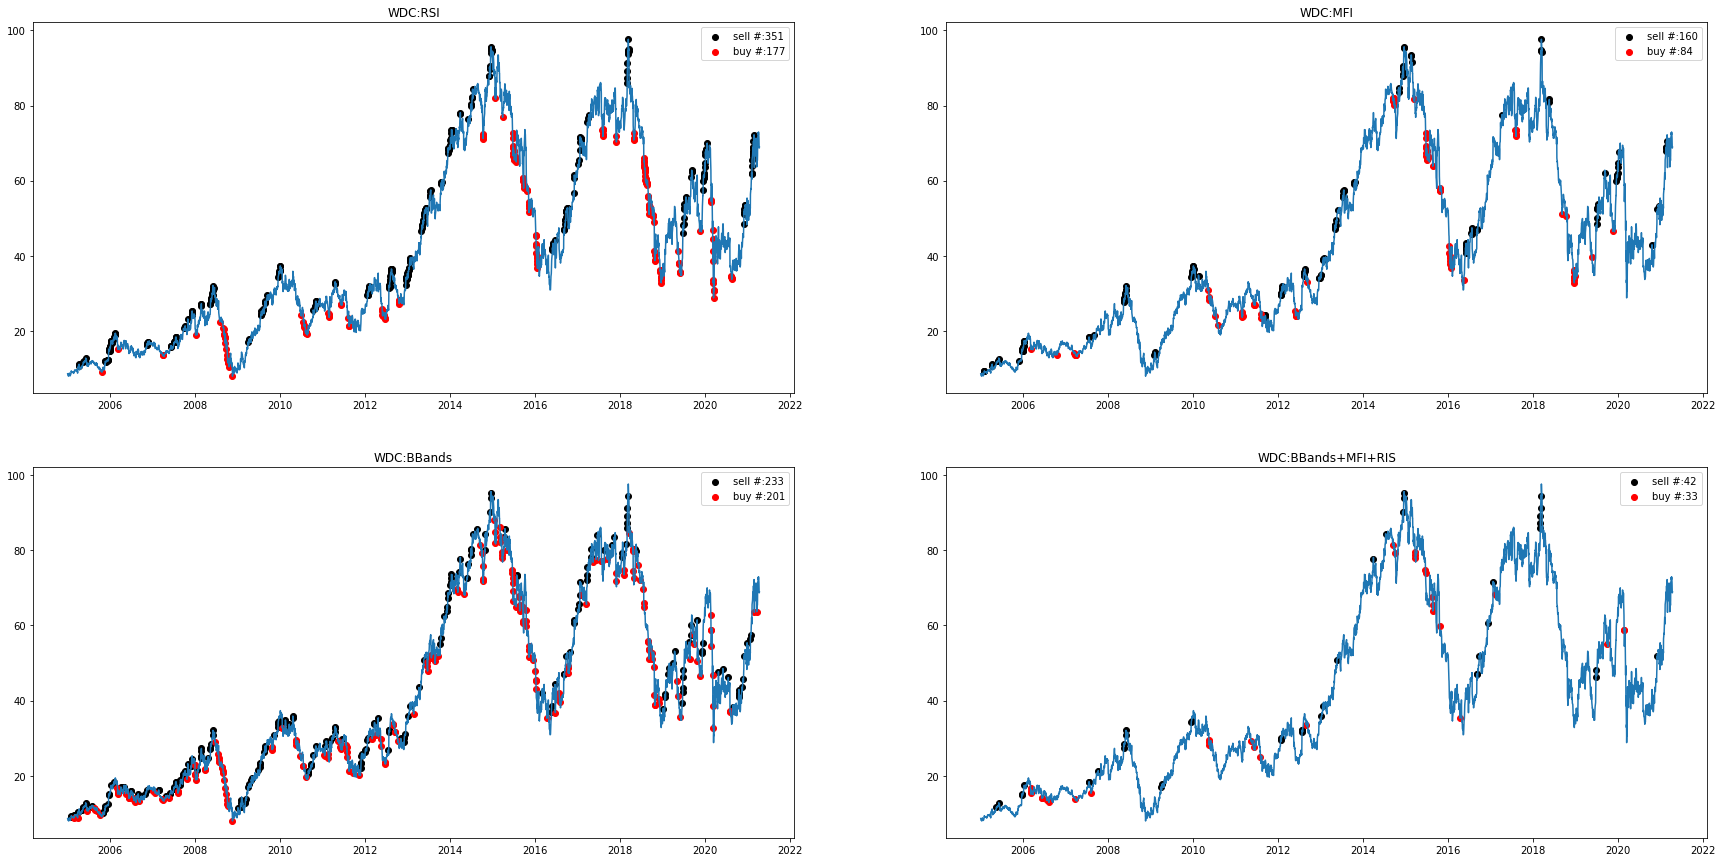

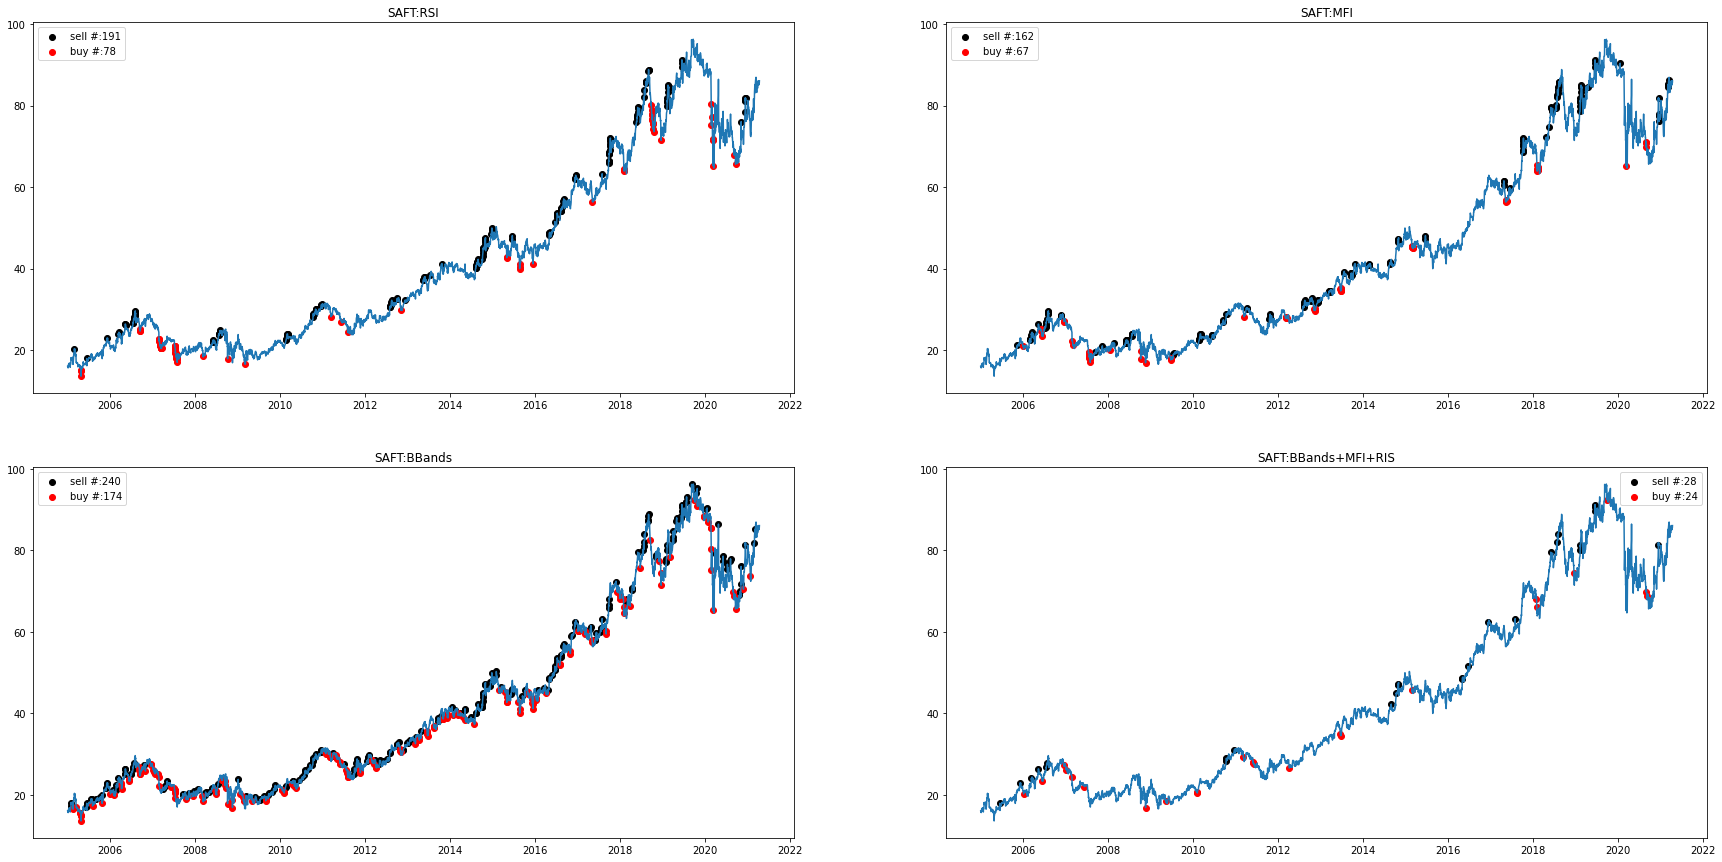

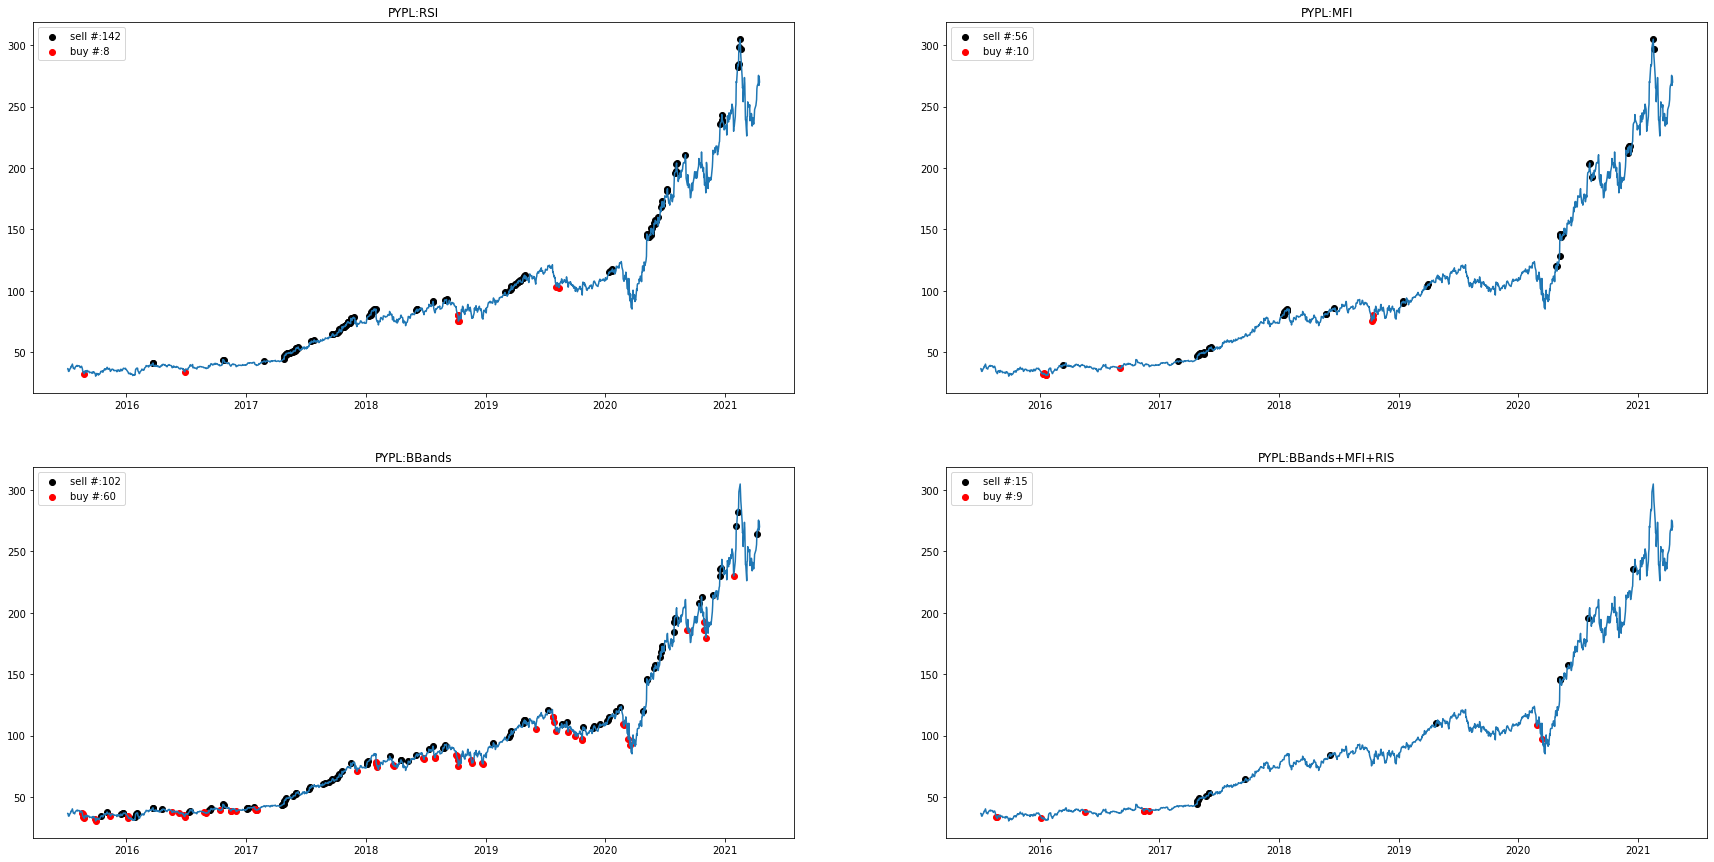

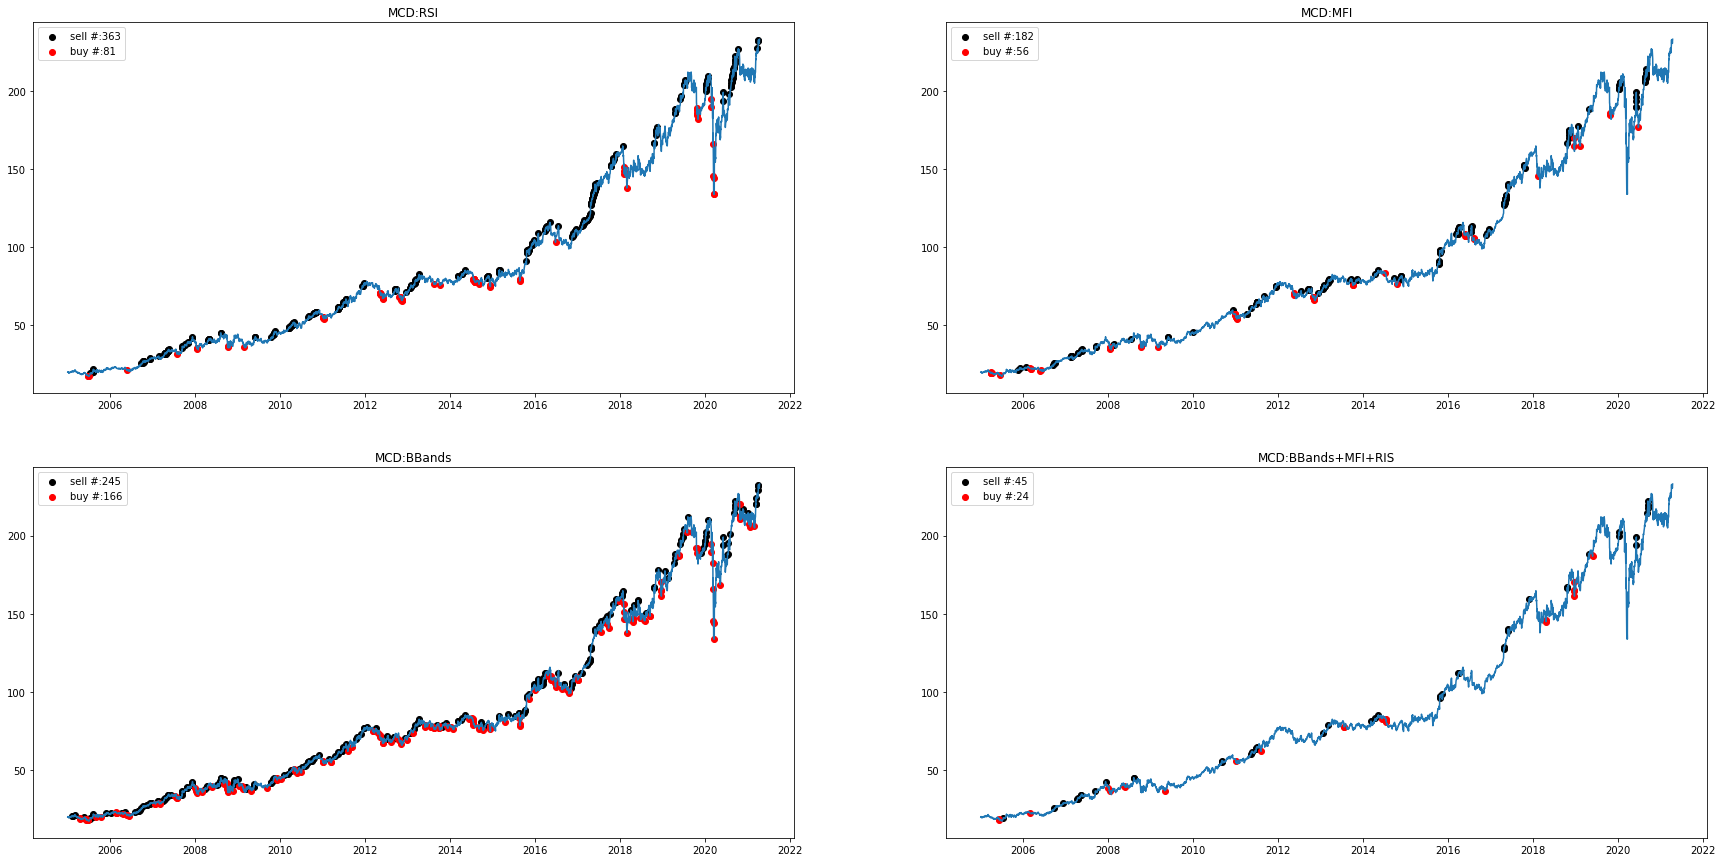

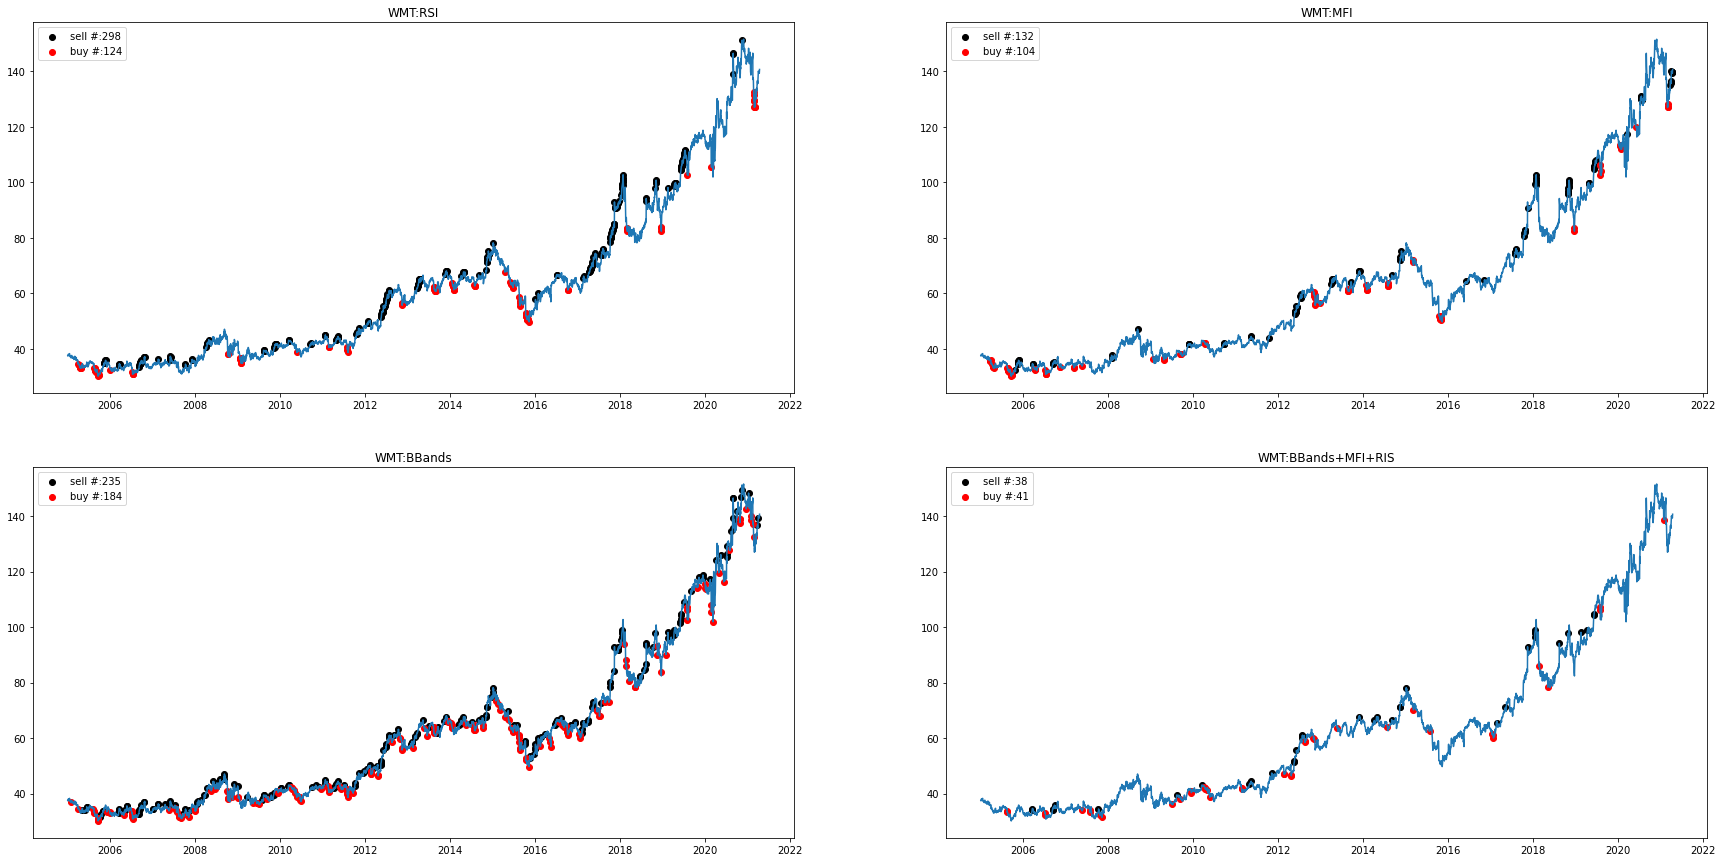

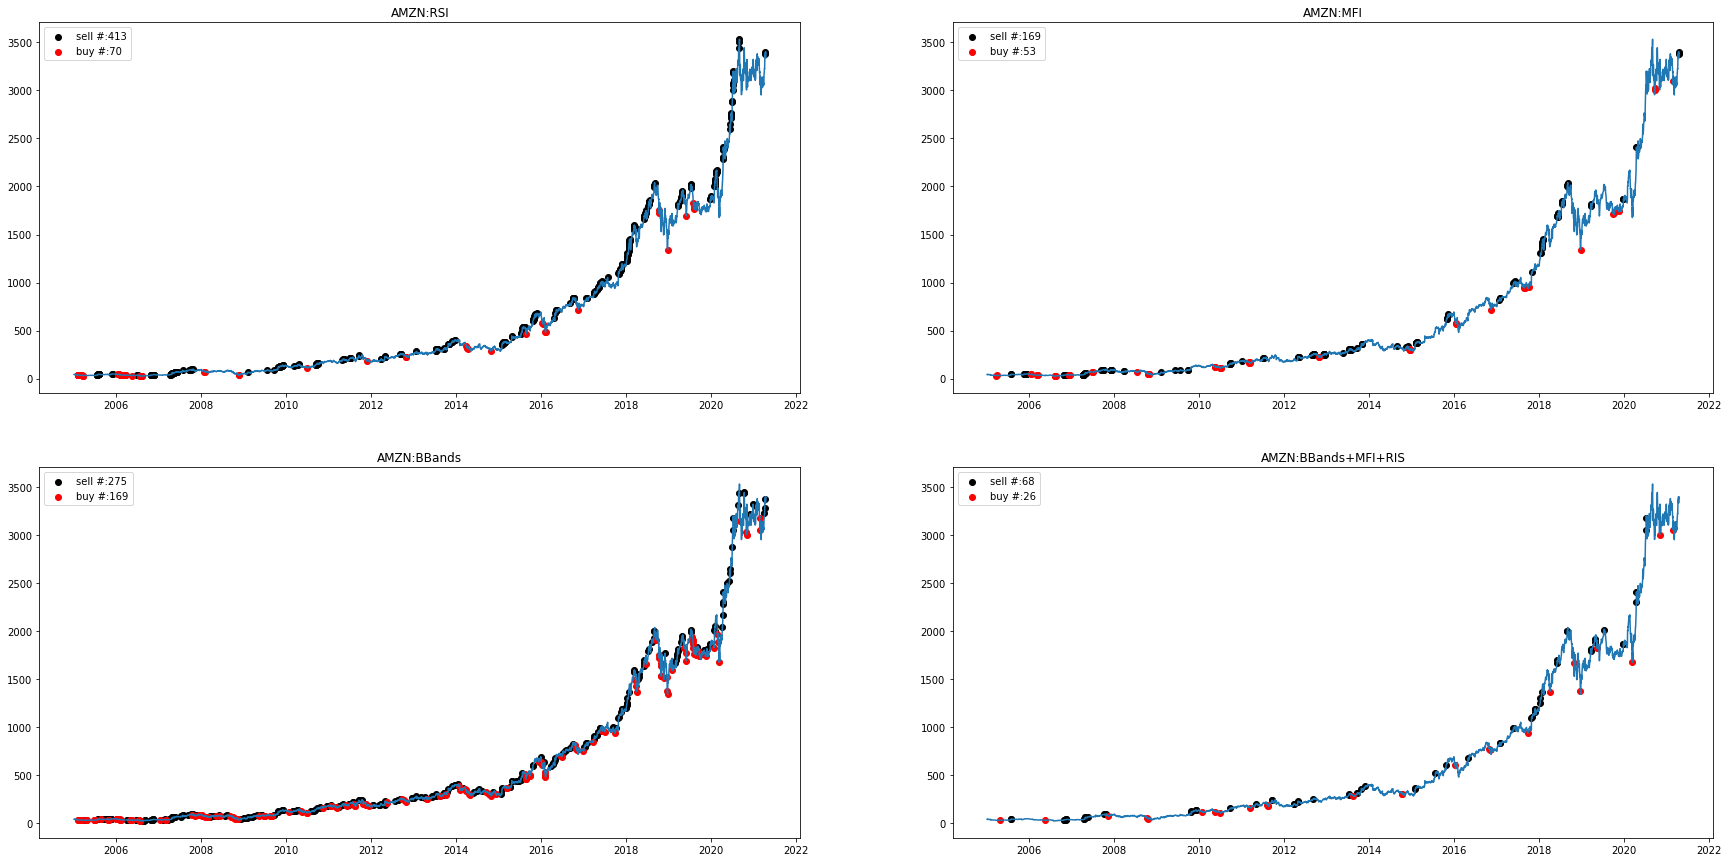

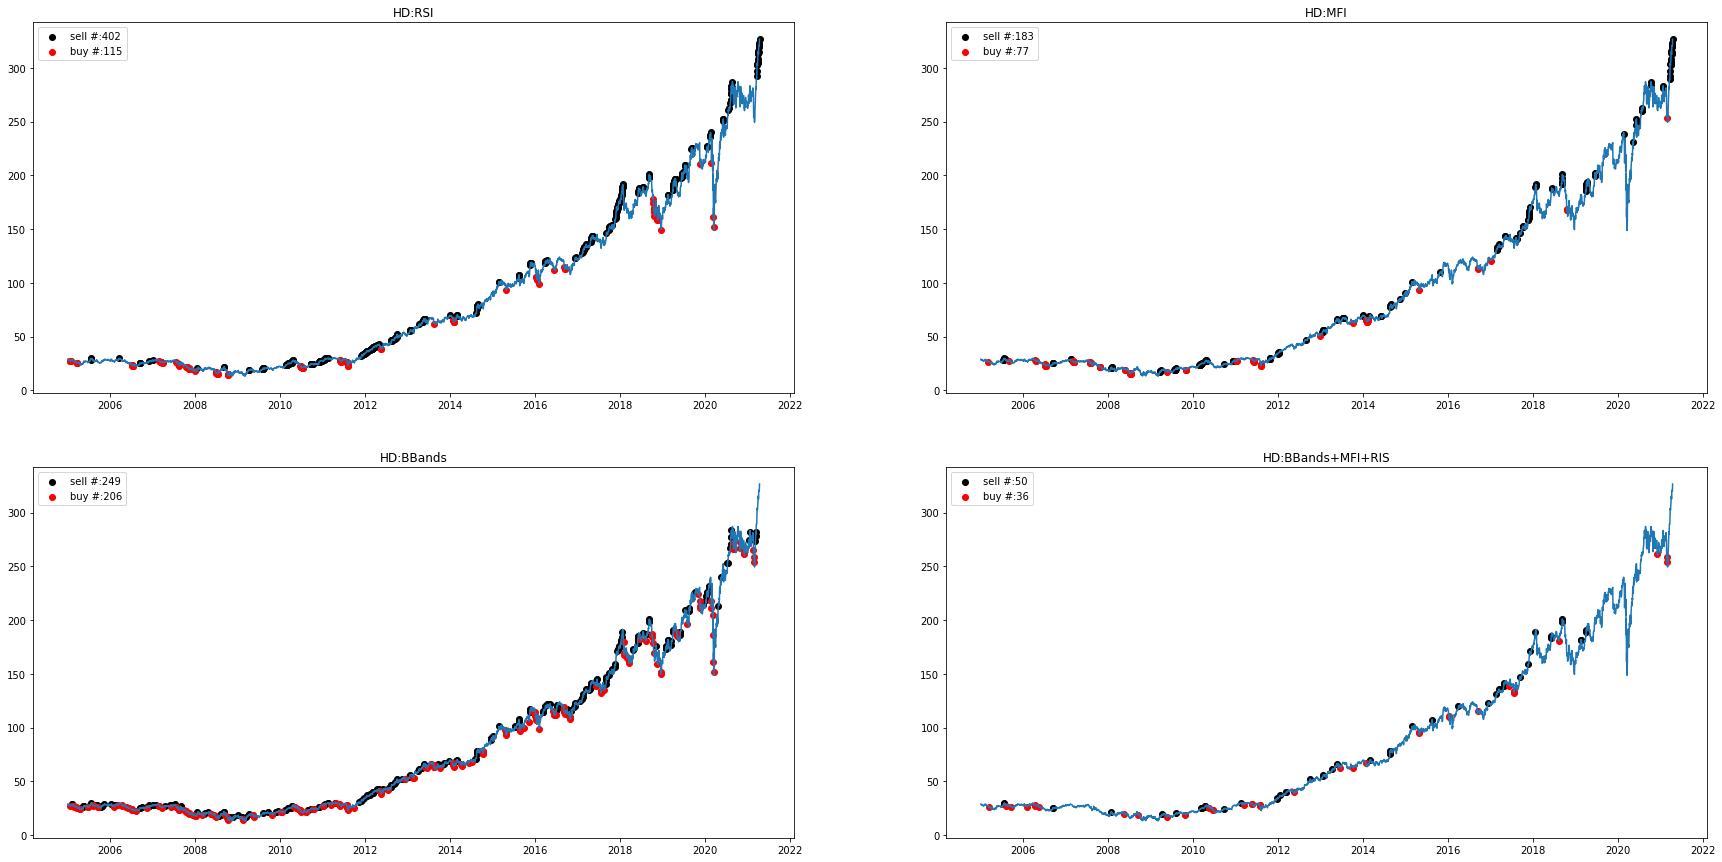

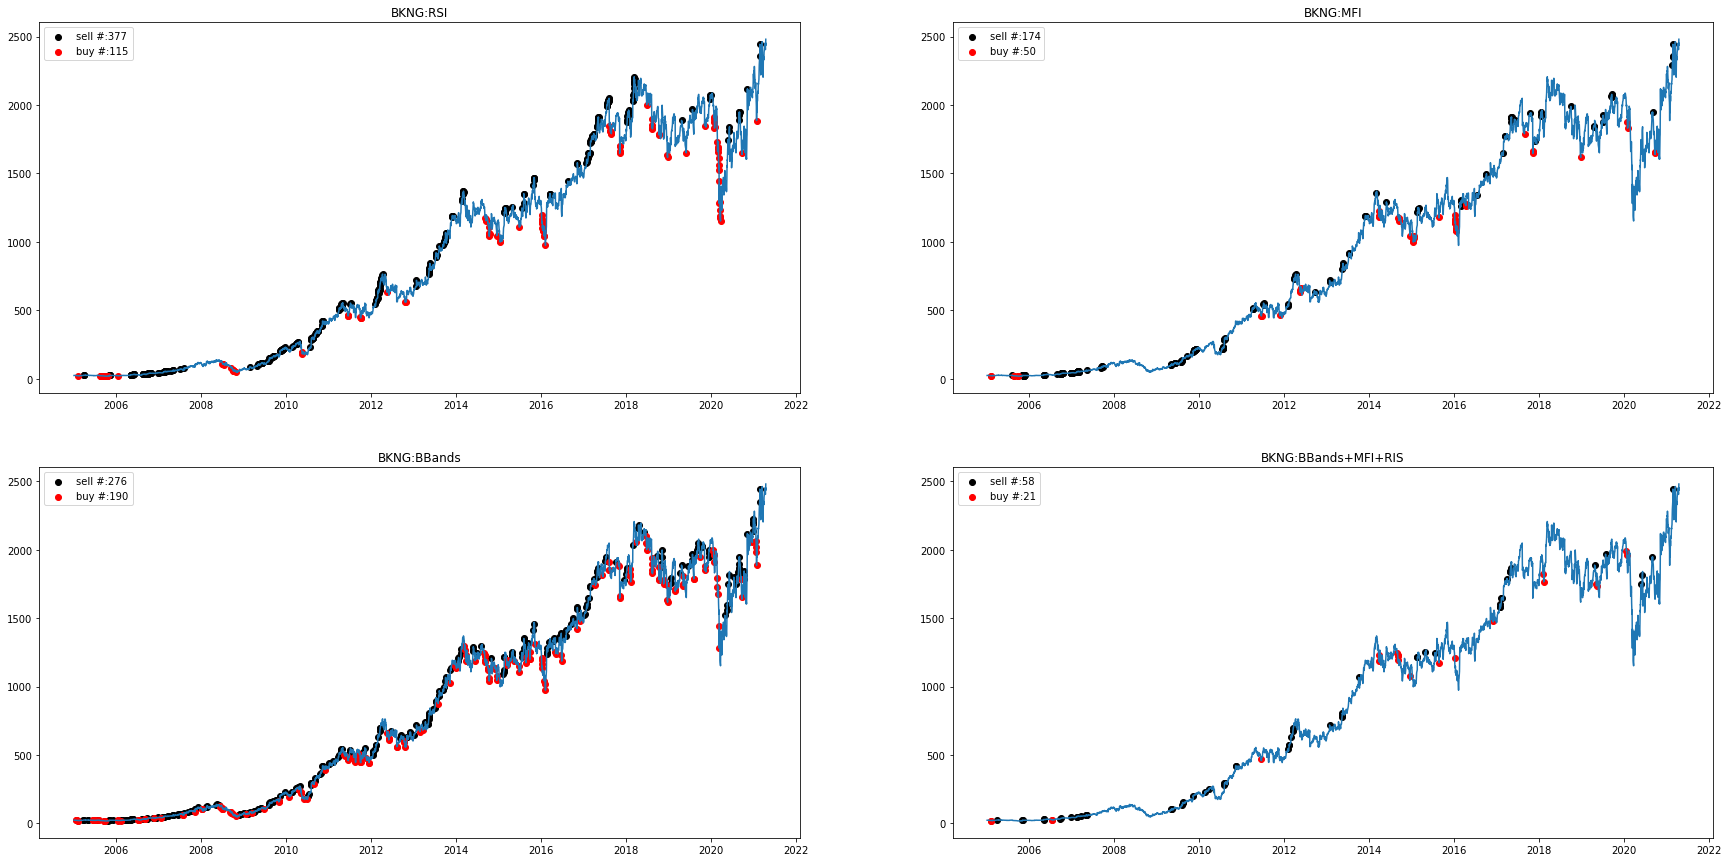

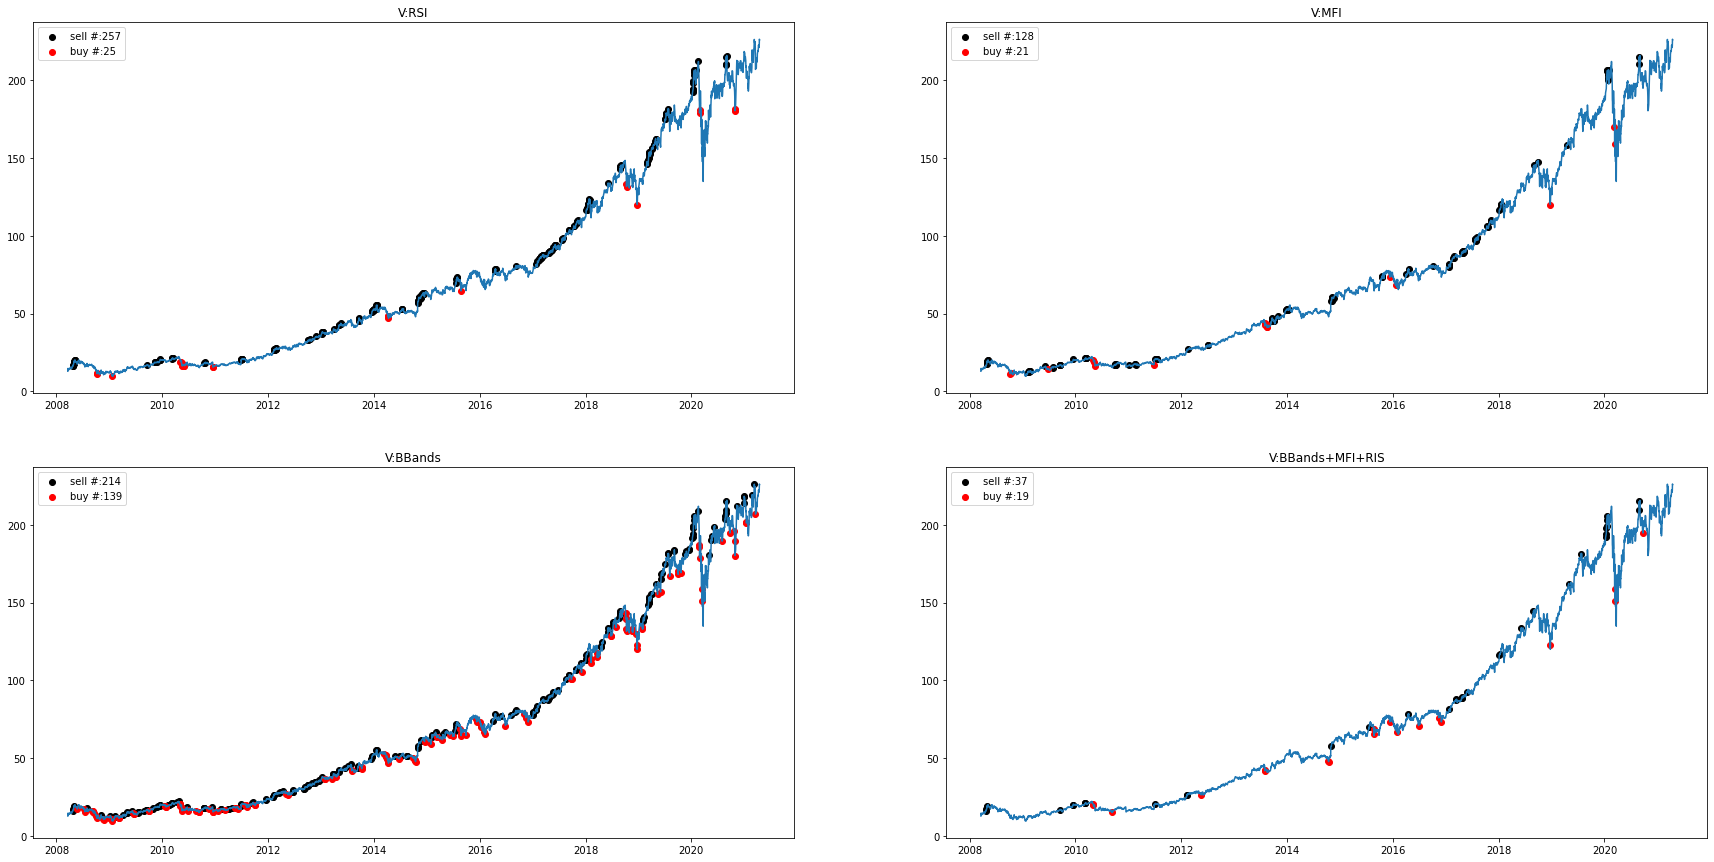

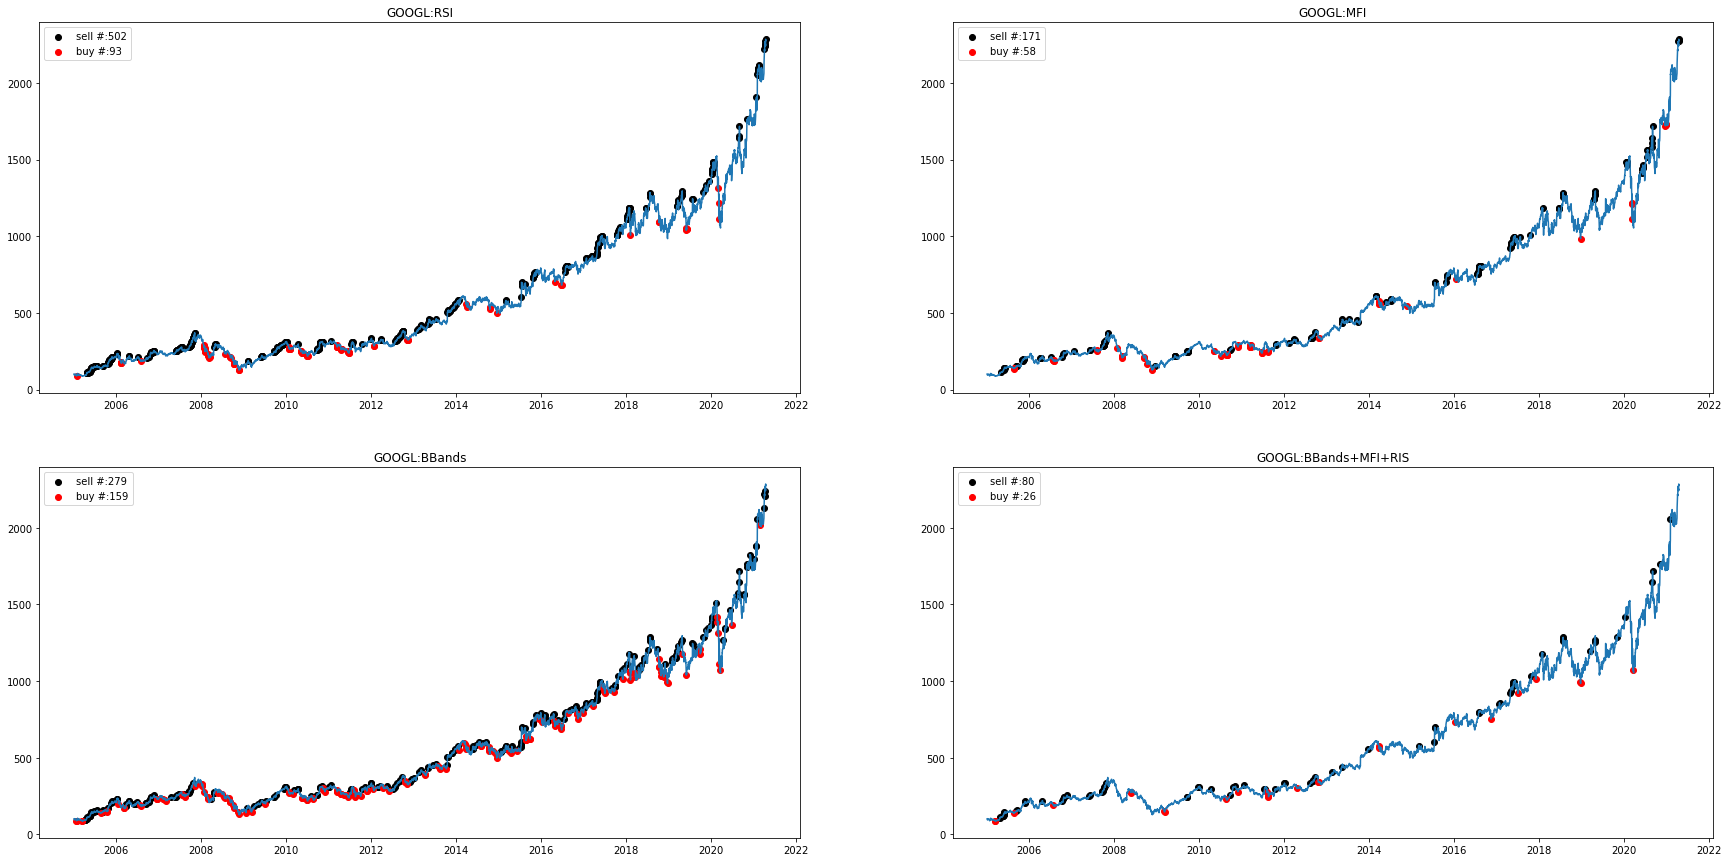

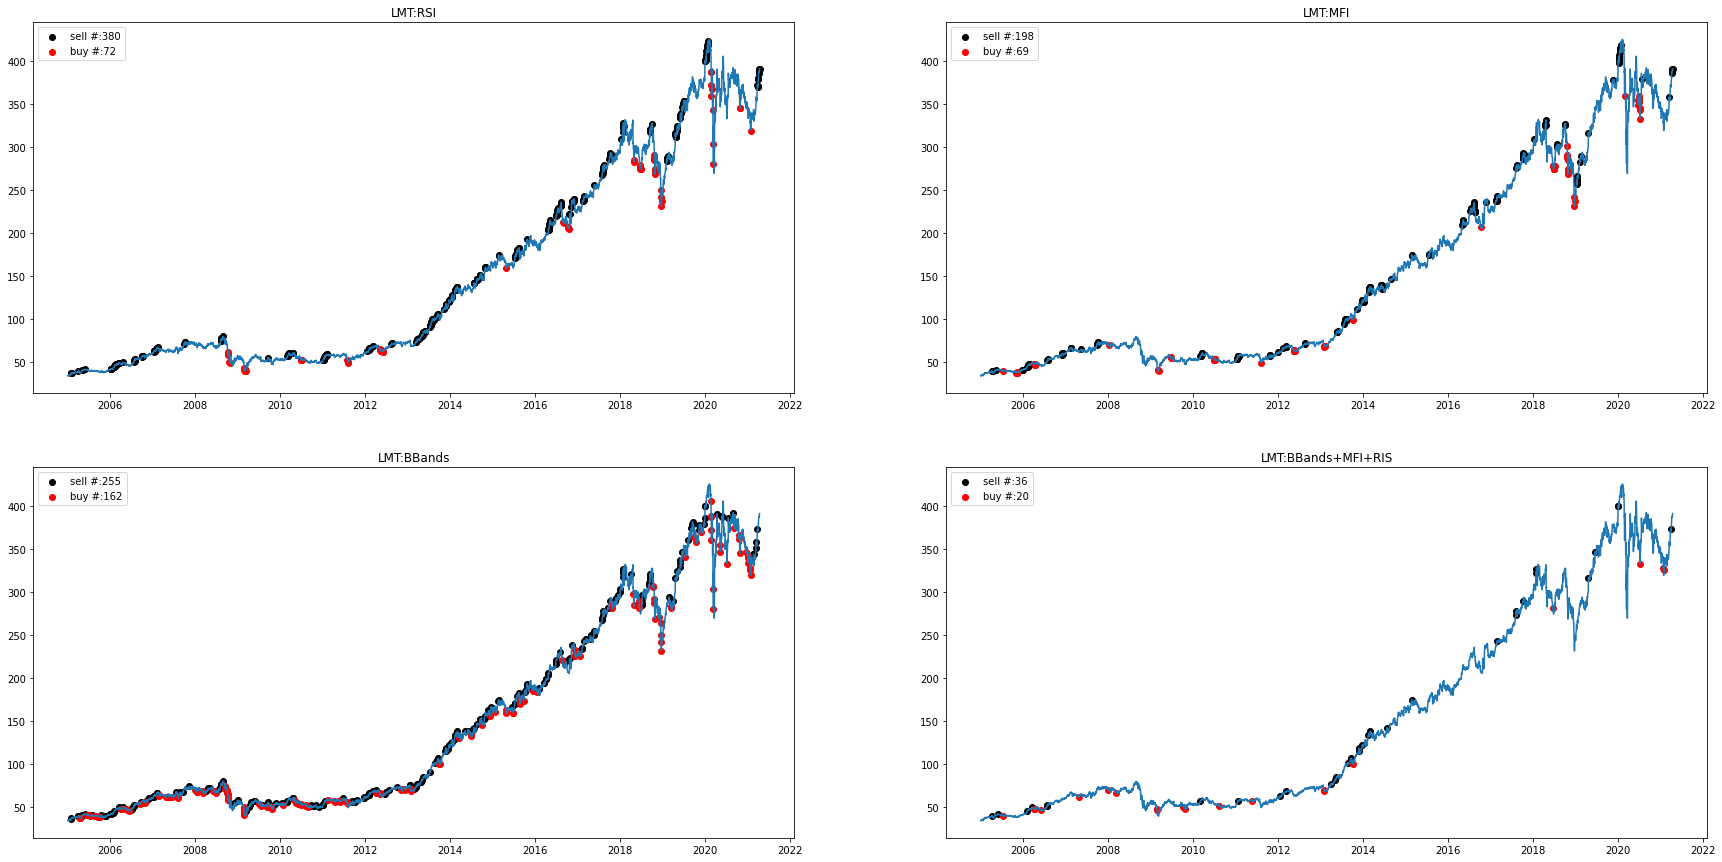

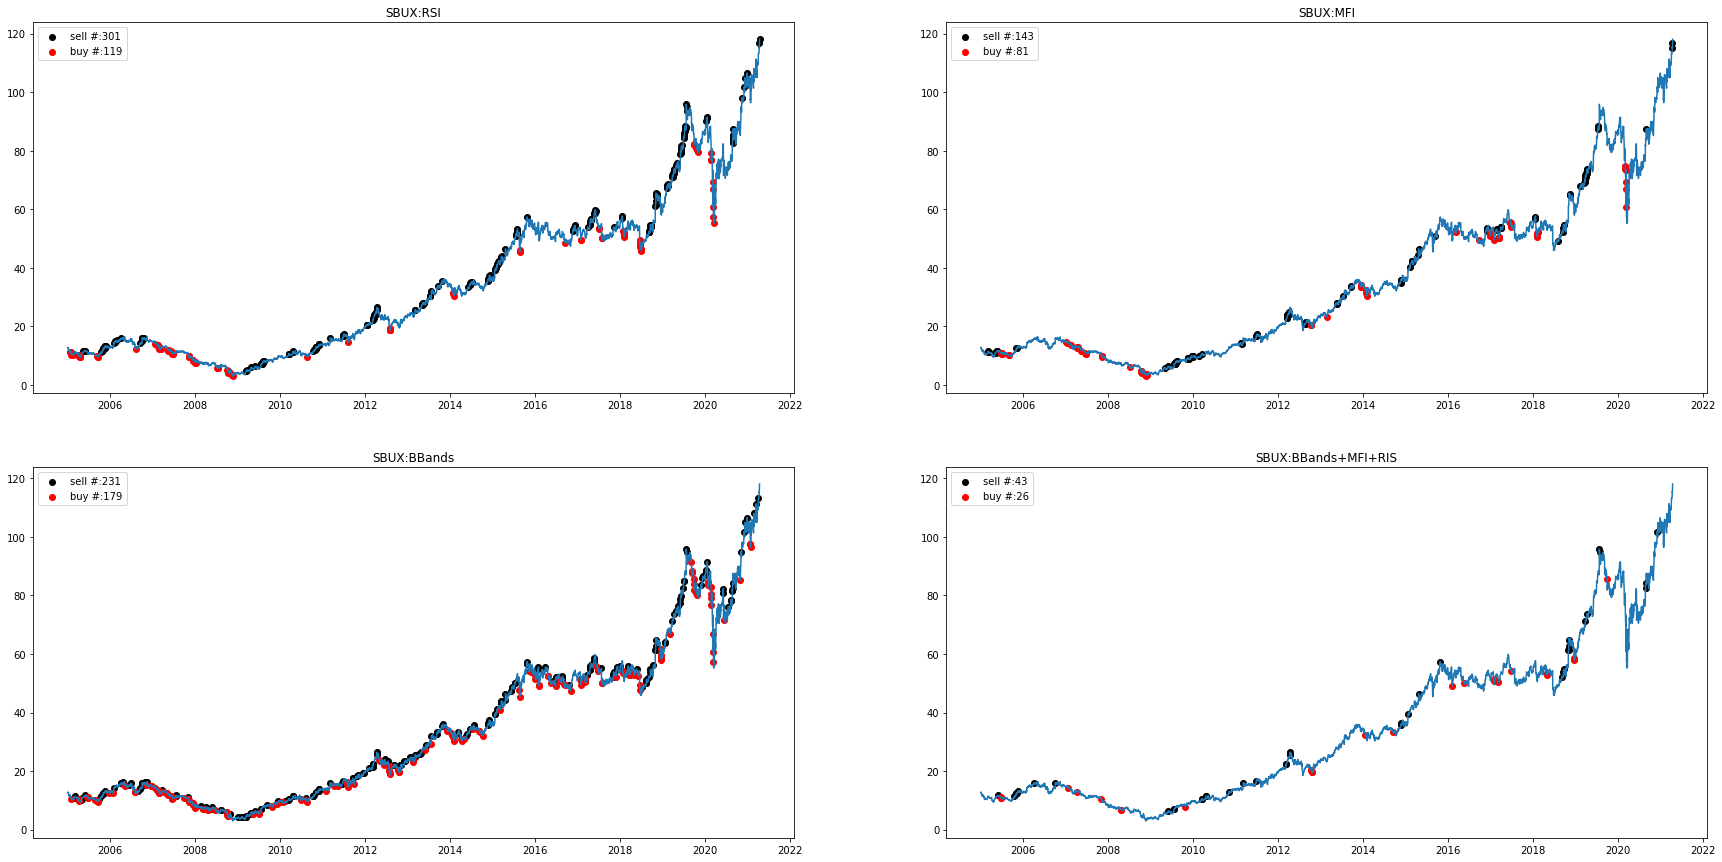

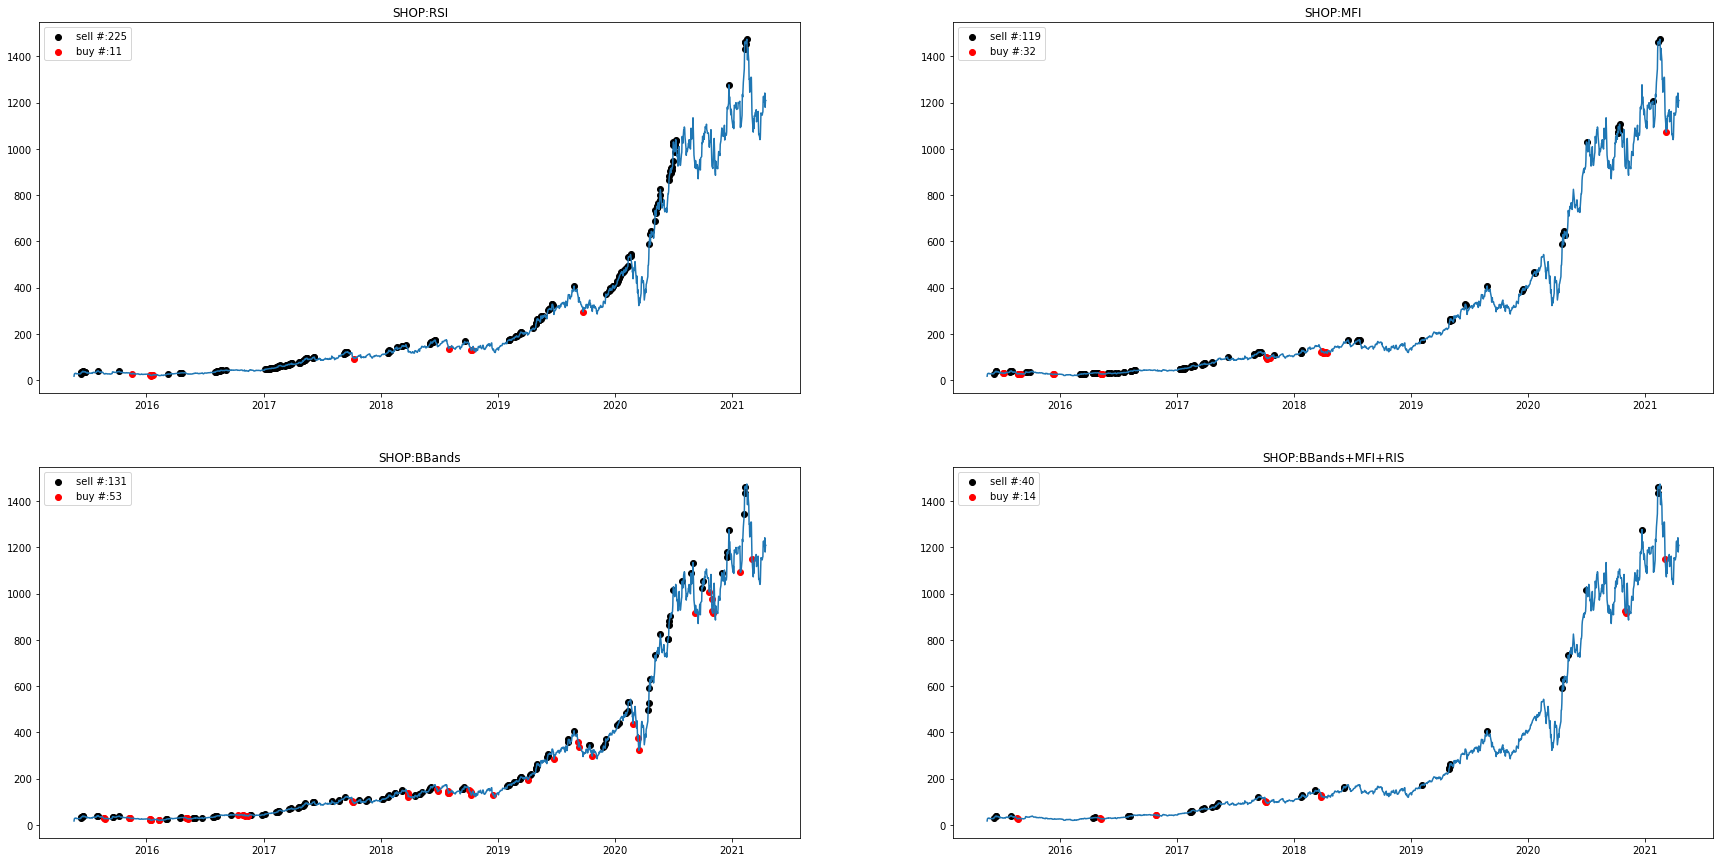

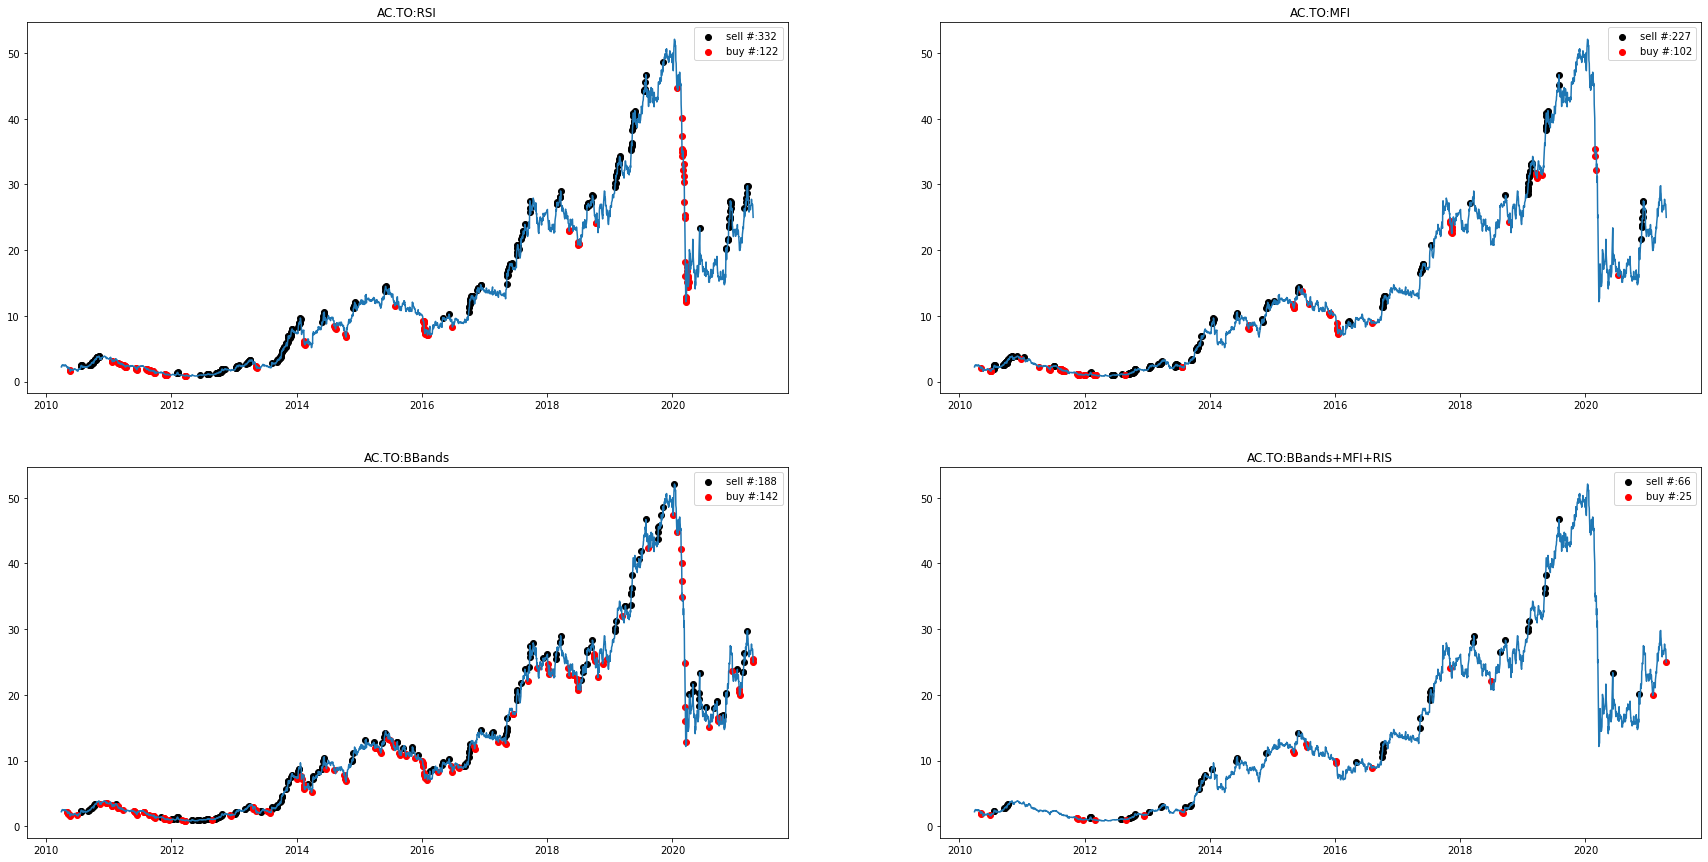

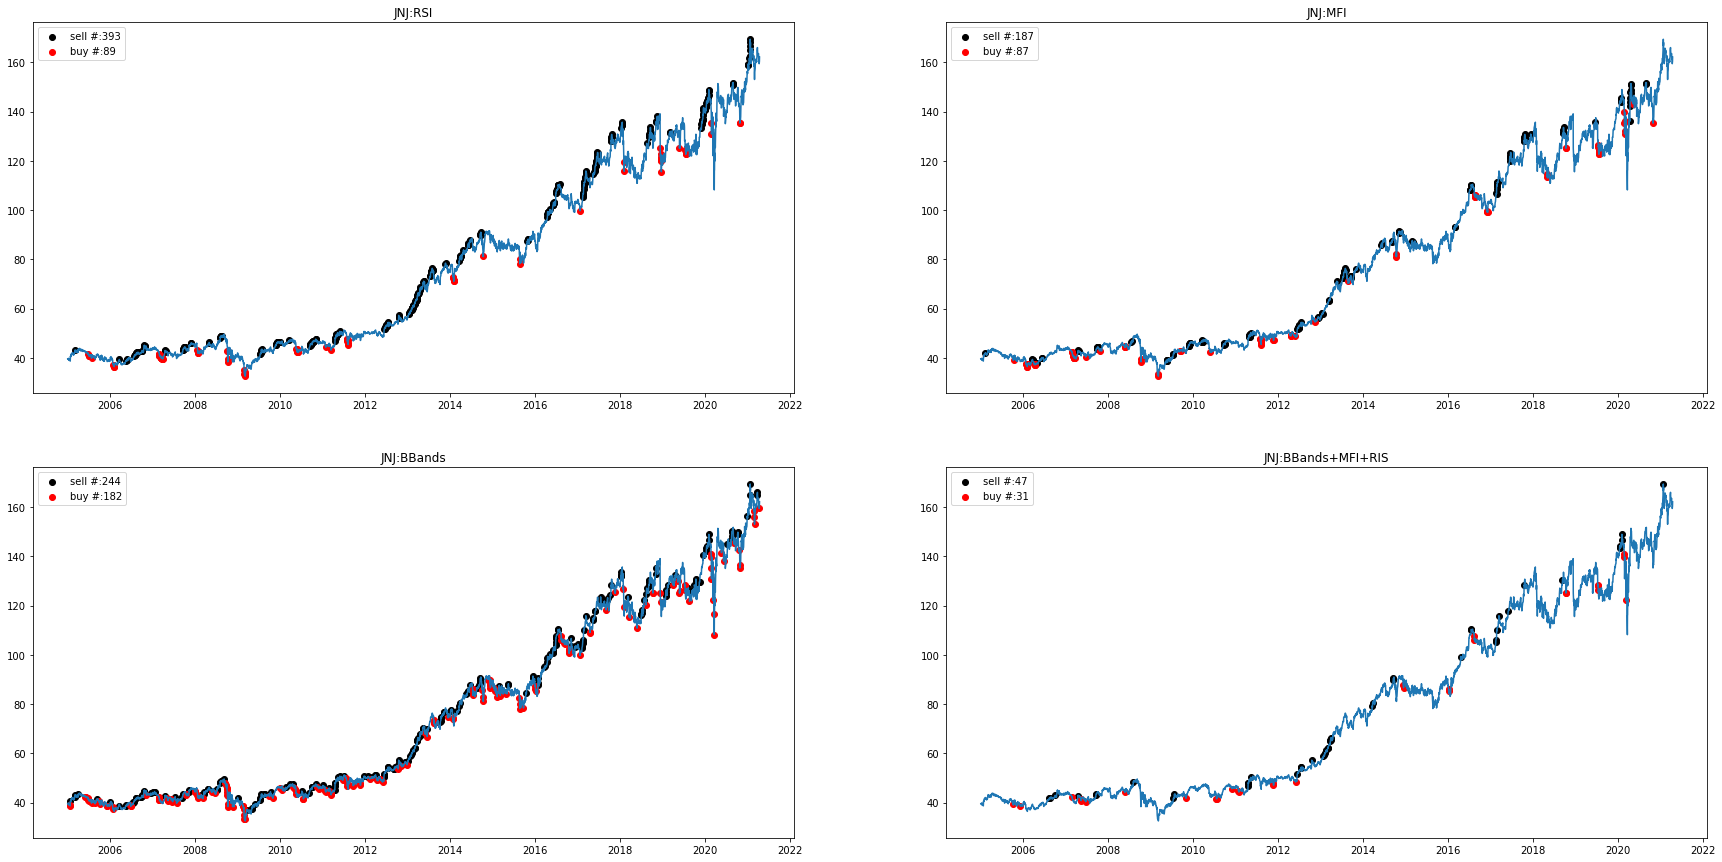

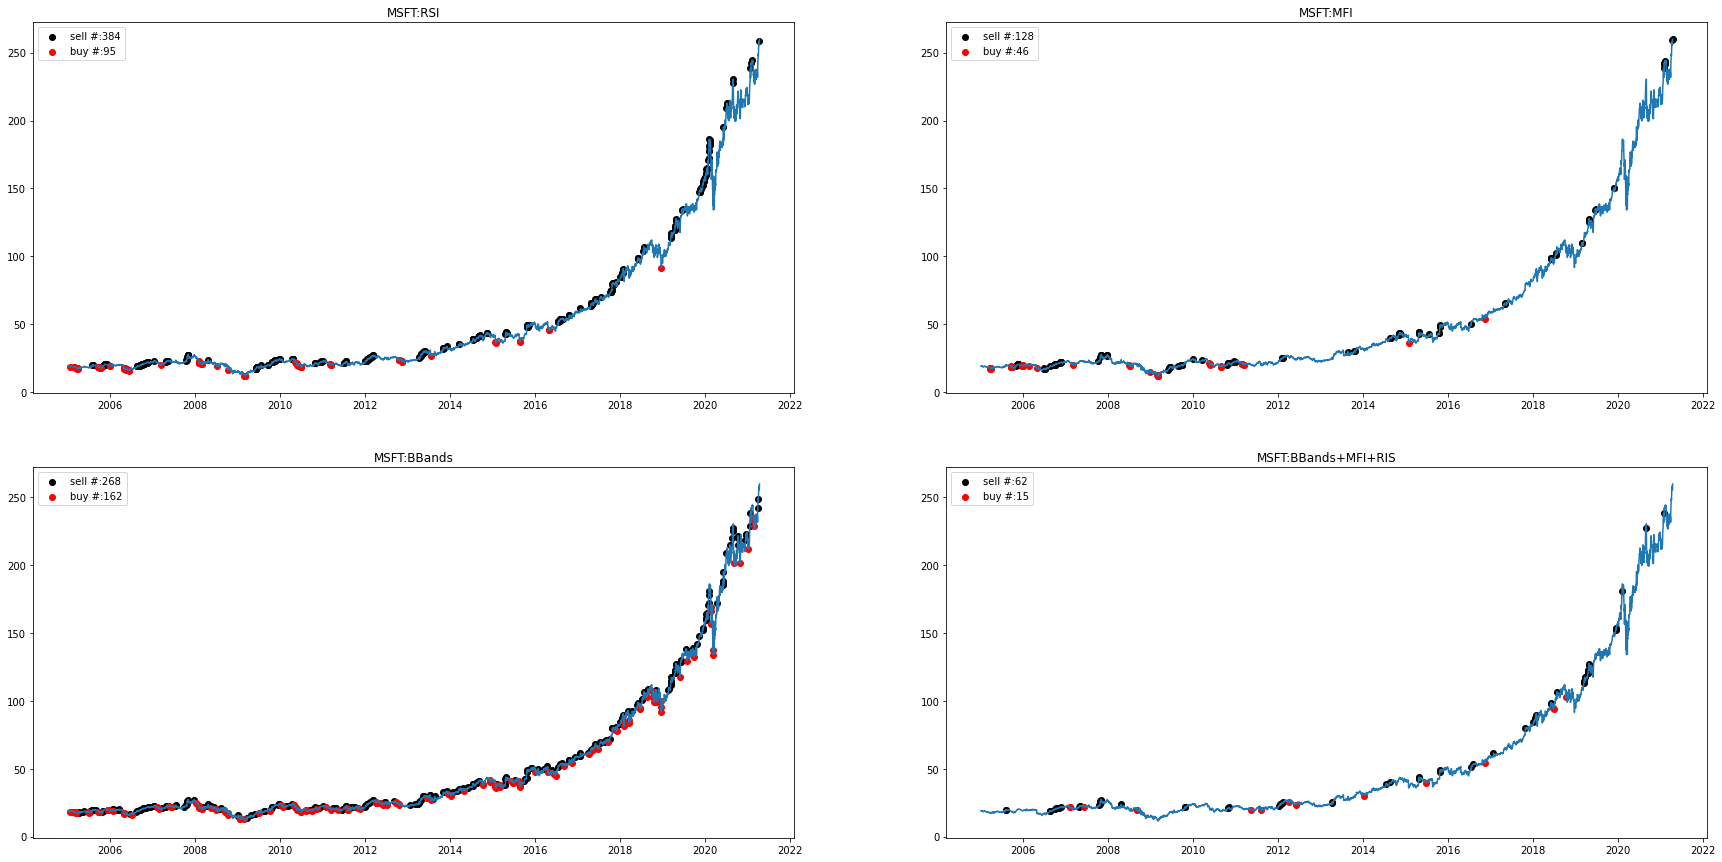

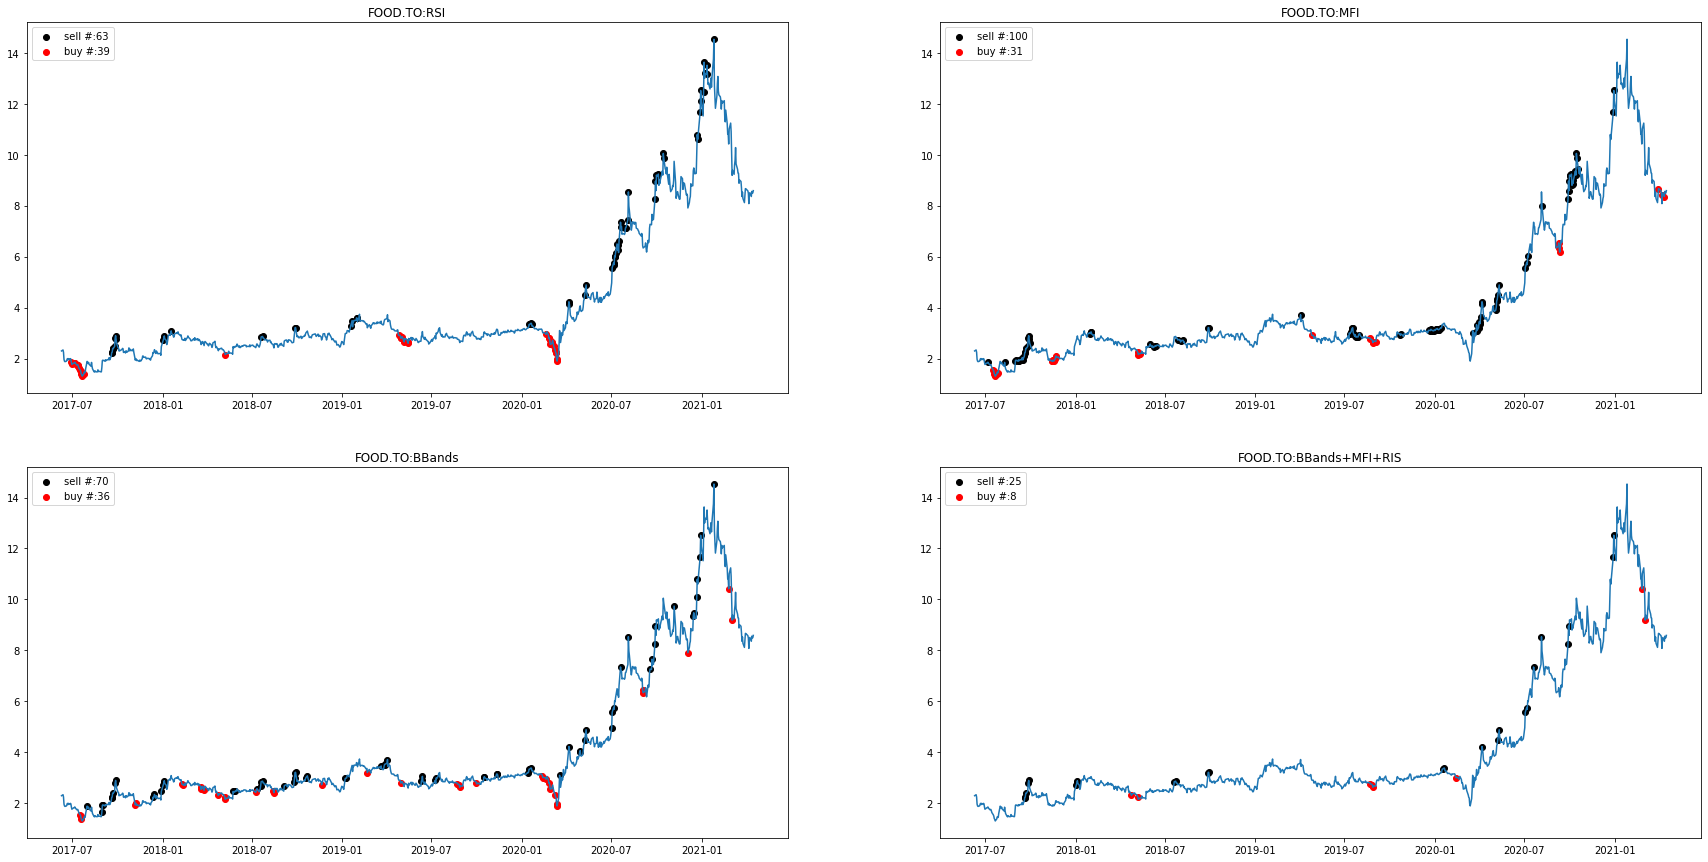

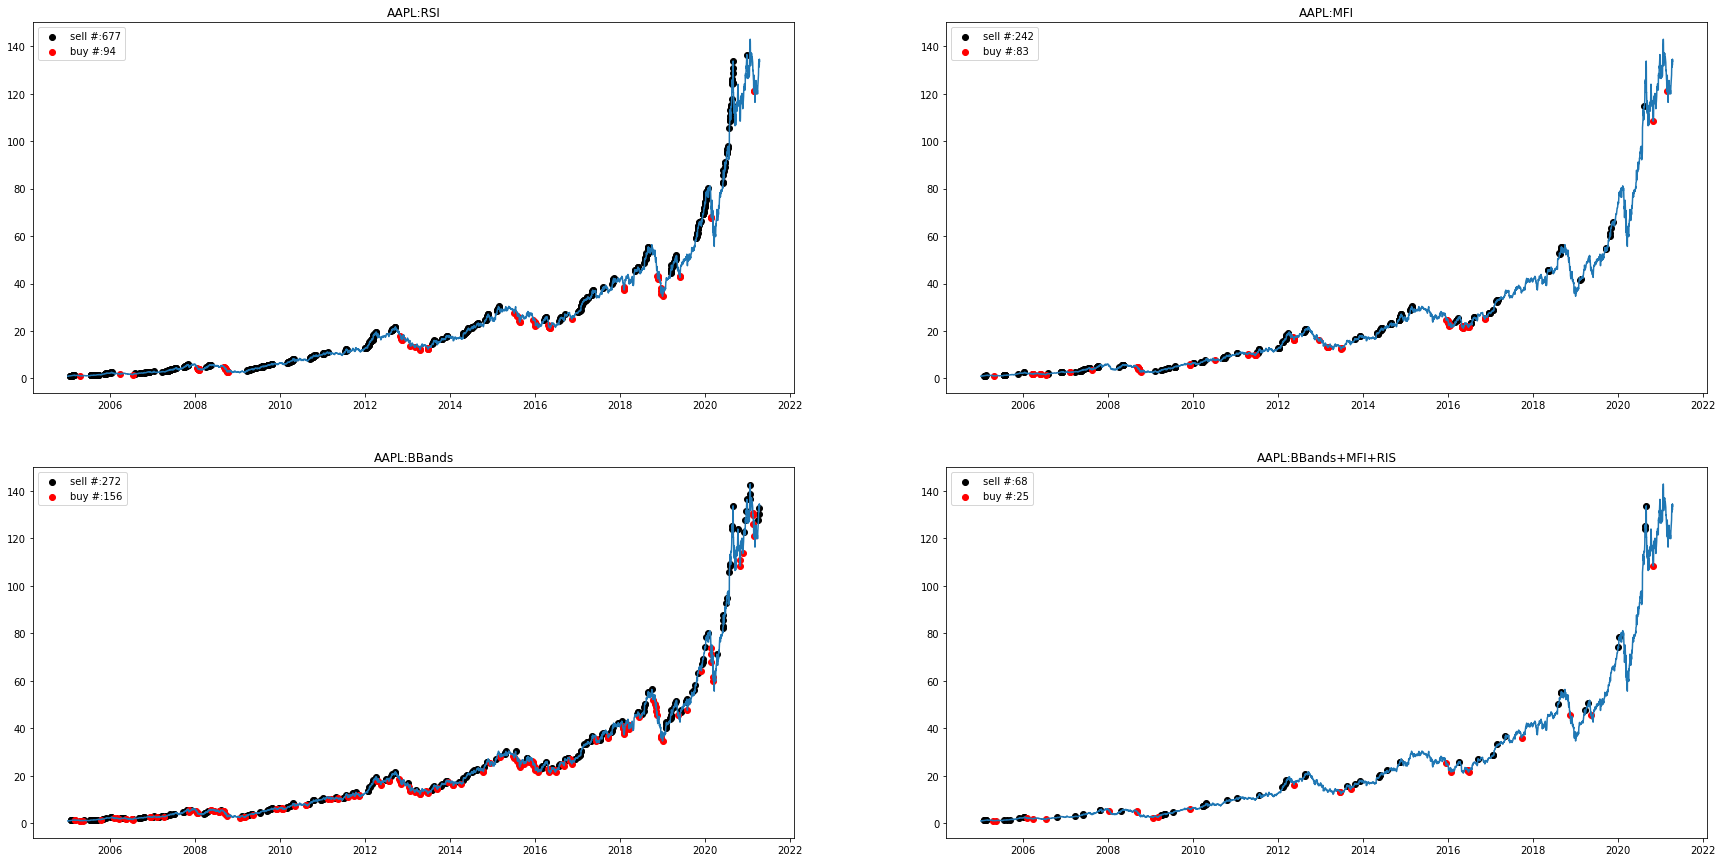

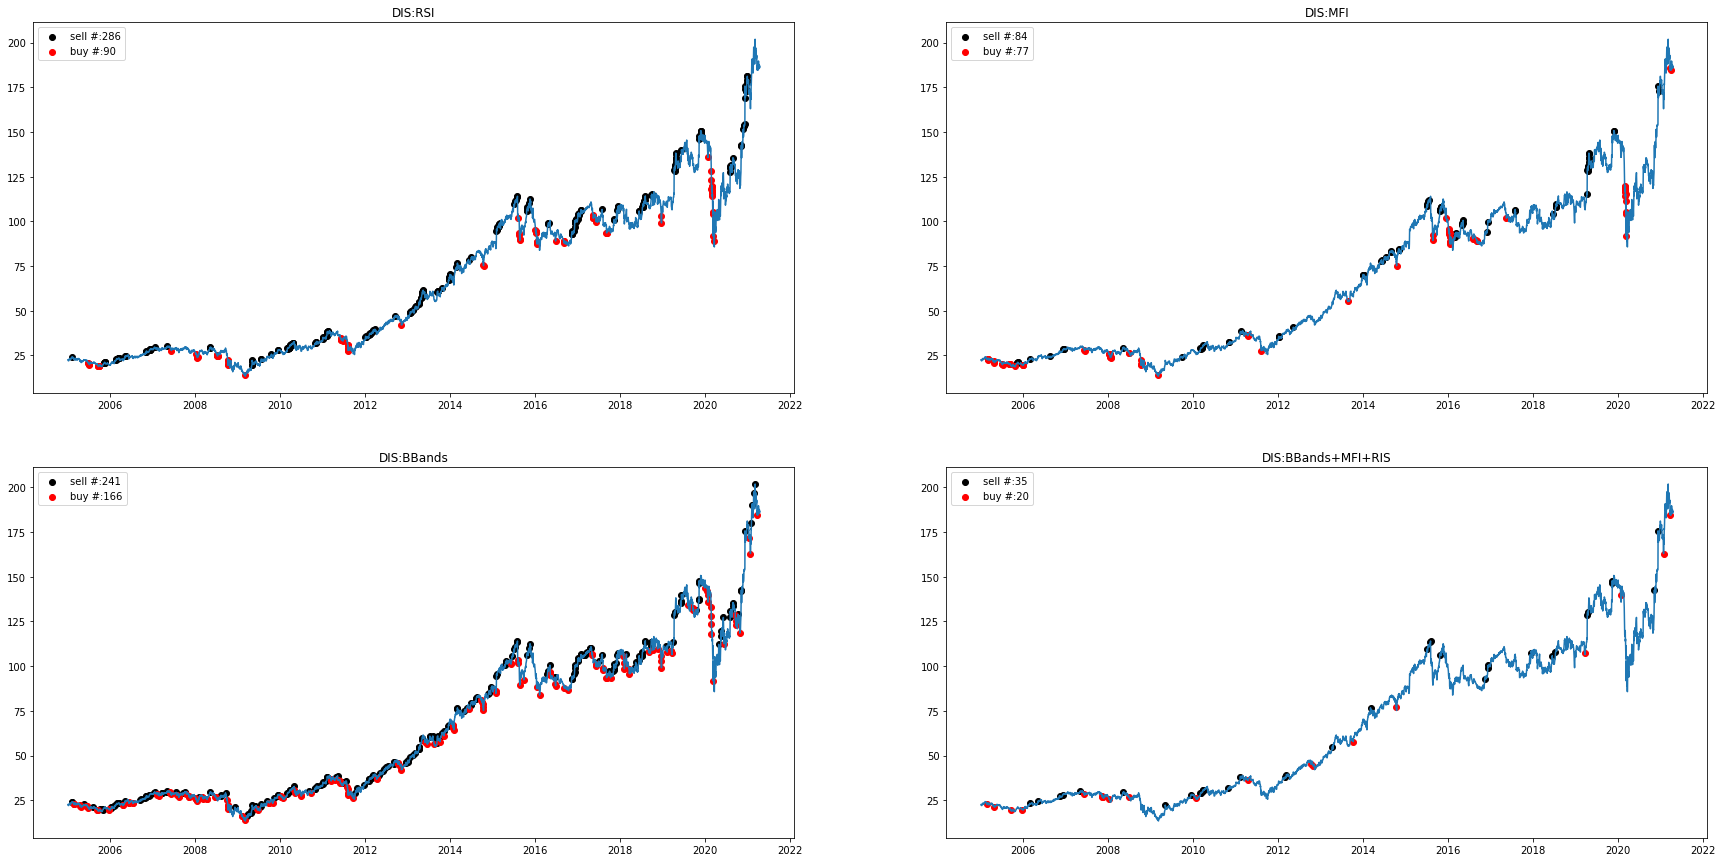

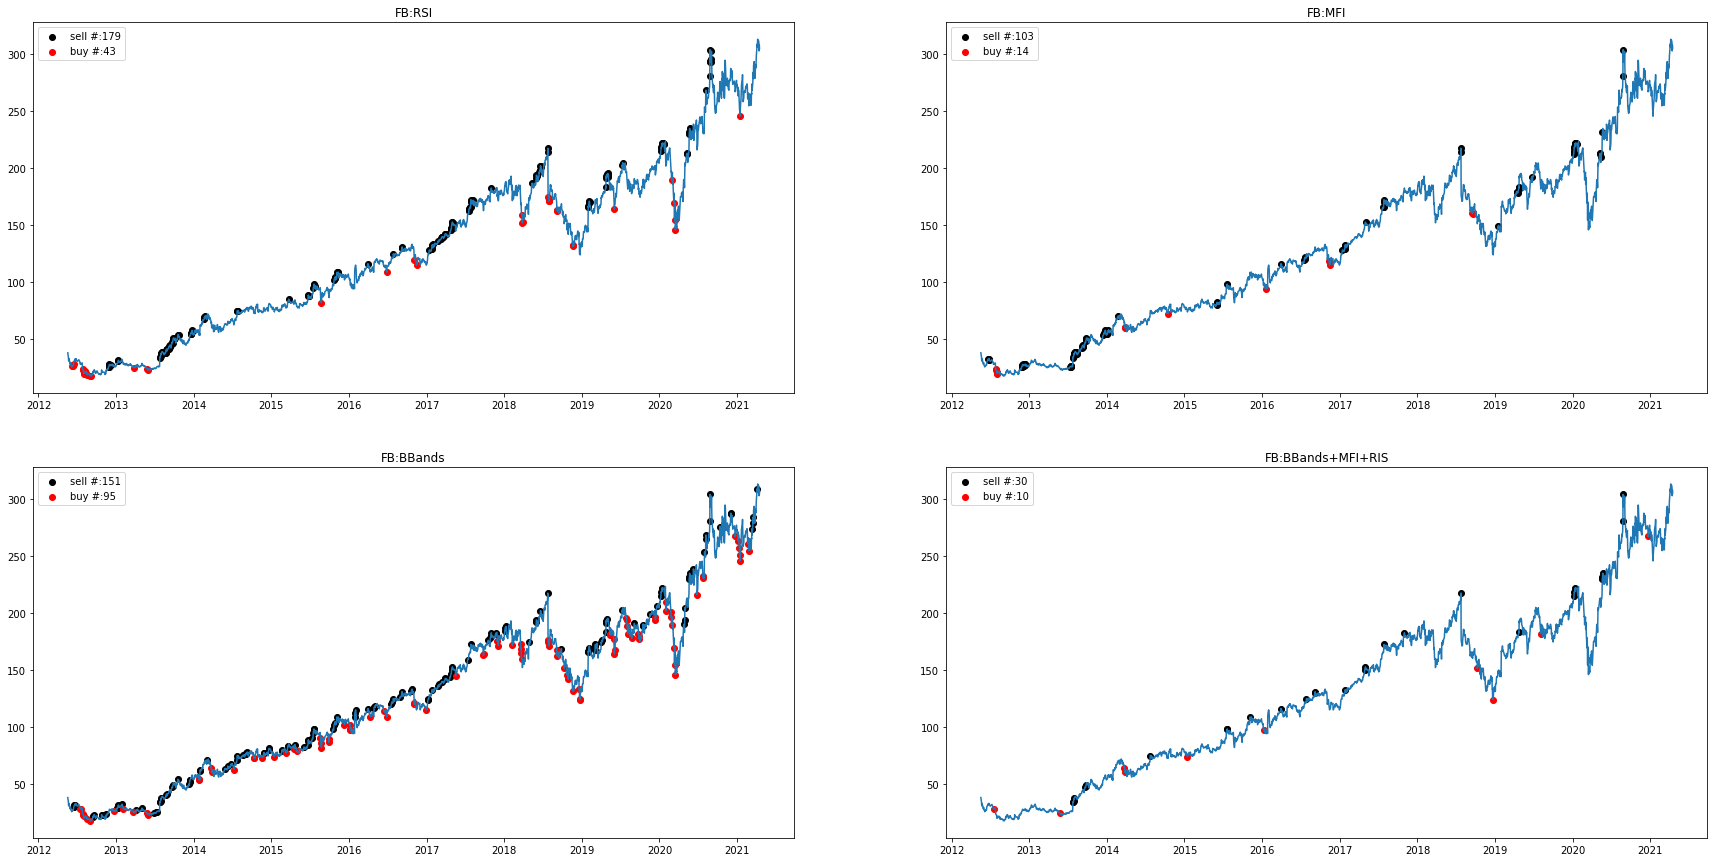

In [135]:
stockList={ 'SAFT','AC.TO','TSLA','DIS','FB','BMO','V','MA','PYPL','ABT','JNJ','AAPL','ADBE','GOOGL','AMD','CSU.TO','HD','BA','ENB','LMT','MCD','SBUX','FOOD.TO','MSFT','SHOP','IBM','BKNG','AMZN','BABA','WMT','WDC'}
for stocks in stockList:
  stock_daily=returnHistory(stocks,'1d','2005-01-01',today)
  stock_daily['RSI']=tb.RSI(stock_daily['Close'],timeperiod=14)
  bband=tb.BBANDS(stock_daily['Close'],timeperiod=14)
  stock_daily['differnceBetweenUpper']=stock_daily['Close']-bband[0]## has to be positive 
  stock_daily['differnceBetweenLower']=stock_daily['Close']-bband[2]## has to be negative 
  stock_daily['MFI']=tb.MFI(stock_daily['High'],stock_daily['Low'],stock_daily['Close'],stock_daily['Volume'],timeperiod=14)
  plotIndicatorBuySell(stock_daily,stocks)

In [58]:
stockList={'amd','baba','DIS','DKNG','AAPL'}
for stocks in stockList:
  stock_daily=returnHistory(stocks,'1d','2013-01-01',today)
  stock_daily['VWAP']=stock_daily.groupby(stock_daily.index.date).apply(lambda x: ((x['High']+x['Low']+x['Close'])/3*x['Volume']).cumsum()/x['Volume'].cumsum()).reset_index()[0].values
  stock_daily['RSI']=tb.RSI(stock_daily['Close'],timeperiod=14)
  bband=tb.BBANDS(stock_daily['Close'],timeperiod=14)
  stock_daily['differnceBetweenUpper']=stock_daily['Close']-bband[0]## has to be positive 
  stock_daily['differnceBetweenLower']=stock_daily['Close']-bband[2]## has to be negative 
  stock_daily['MFI']=tb.MFI(stock_daily['High'],stock_daily['Low'],stock_daily['Close'],stock_daily['Volume'],timeperiod=14)
  plotIndicatorBuySell(stock_daily,stocks)

In [132]:
bband[0]

Date
2017-06-09         NaN
2017-06-12         NaN
2017-06-13         NaN
2017-06-14         NaN
2017-06-15         NaN
                ...   
2021-04-12    8.807961
2021-04-13    8.776040
2021-04-14    8.784447
2021-04-15    8.780364
2021-04-16    8.794343
Length: 967, dtype: float64

In [127]:
stock_daily=returnHistory('FOOD.TO','1d','2005-01-01',today)
stock_daily['RSI']=tb.RSI(stock_daily['Close'],timeperiod=14)
bband=tb.BBANDS(stock_daily['Close'],timeperiod=14)
stock_daily['differnceBetweenUpper']=stock_daily['Close']-bband[0]## has to be positive 
stock_daily['differnceBetweenLower']=stock_daily['Close']-bband[2]## has to be negative 

Open  High  ...  differnceBetweenUpper  differnceBetweenLower
Date                    ...                                              
2017-06-09  2.40  2.40  ...                    NaN                    NaN
2017-06-12  2.40  2.40  ...                    NaN                    NaN
2017-06-13  2.37  2.37  ...                    NaN                    NaN
2017-06-14  2.24  2.25  ...                    NaN                    NaN
2017-06-15  1.95  1.95  ...                    NaN                    NaN
...          ...   ...  ...                    ...                    ...
2021-04-12  8.48  8.48  ...              -0.447962               0.290818
2021-04-13  8.31  8.60  ...              -0.216040               0.478898
2021-04-14  8.63  8.70  ...              -0.294447               0.398733
2021-04-15  8.56  8.62  ...              -0.280364               0.408936
2021-04-16  8.62  8.80  ...              -0.234343               0.442915

[967 rows x 10 columns]

 ## Trading Simulations Based on Indicators

The goal here is to investigate what the year over year goal would be for each stock if they followed the indicator .


*   Every year the person would recieve $5000 in the investment back.
*   Everytime  a sell indicator is triggered the person would sell 20% of their stock (unless they are out of stocks).
* Everytime a buy indicator is triggered the person would spend 20% of their portfolio (unless they are out of cash).

The performance of the trades are evaluated at every year. 
Every trade will cost $10.  



